In [1]:
# Pruebas de mapas nacionales y subnacionales

import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import geopandas as gpd

In [2]:
# Datos

# Carpetas
path_catalog = "../../Bases_de_datos/Data_catalog.csv"
path_v = "../data/variables.csv"
map_d = "../../Bases_de_datos/Mapas/"
data_d = "../results/"
wb_path = "../../Bases_de_datos/World_Bank_CCKP/"

# Mapas
map_f = [ "Natural_Earth/ne_50m_admin_0_countries_mod",
    "Natural_Earth/ne_10m_admin_0_countries",
    "Natural_Earth/ne_10m_admin_1_states_provinces",
    "Natural_Earth/ne_10m_admin_1_states_provinces_mod",
    "OECD/OECD_TL2_shapefile",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_RUSSIA_CHINA_INDIA.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_BRAZIL.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_COLOMBIA.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_PERU.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_SOUTH_AFRICA.shp" ]

# Datos OCDE
data_f = [ "Deciles_climate.csv", "Deciles_governance.csv",
    "Deciles_socioeconomic.csv", "countries_values_net_zero.csv",
    "Values_climate.csv", "Values_governance.csv",
    "Values_socioeconomic.csv" ]

# Códigos nacionales y subnacionales
ix  = "alpha-3"
ix1 = "iso_3166_2" 

# Relación de códigos Banco Mundial y Natural Earth (ISO 3166-2)
code_path = "../../Bases_de_datos/Subnational_Code_WB_ISO.csv"

# Catálogo de datos
df_c = pd.read_csv(path_catalog)
# Variables utilizadas para el índicador de resiliencia
df_v = pd.read_csv(path_v)

# Mapas
gdf0_50 = gpd.read_file( map_d + map_f[0] ).rename(
    columns = {"GU_A3": ix} ).set_index( ix )
gdf0_10 = gpd.read_file( map_d + map_f[1] ).rename( 
    columns = {"GU_A3": ix1} ).set_index( ix1 )
gdf1_50 = gpd.read_file( map_d + map_f[2] ).set_index( ix1 )
gdf1_mod = gpd.read_file( map_d + map_f[3] ).set_index( ix1 )

# Datos a graficar
df_1   = pd.read_csv( data_d + data_f[3], index_col = ix )
df_2 = pd.read_csv( data_d + data_f[0], index_col = ix )
df_3 = pd.read_csv( data_d + data_f[4], index_col = ix )

# Unimos los datos y el mapa
gdf_2 = gdf0_50.merge(df_1, how = "left",
    left_index = True, right_index = True )
gdf_3 = gdf_2.merge( df_2, how = "left",
    left_index = True, right_index = True )
gdf_4 = gdf_2.merge( df_3, how = "left",
    left_index = True, right_index = True )

In [5]:
# Cargamos los datos del World Bank y los unimos a un mapa
# Number of hot days per year above 35°C, 1995-2014

# Variable a estudiar
v = "h35_hist"
# Número de archivo correspondiente
i = 1 # Histórico

# Lista de archivos del World Bank
wb_f = os.listdir(wb_path)
# Los datos se descargan en un Excel
wb_h = pd.read_excel(wb_path + wb_f[i], index_col = "code" )
# Cargamos la relación de códigos.
code_wb = pd.read_csv(code_path, index_col = "code" )
# Usamos solo los datos de los códigos de la relación
# Quitamos datos subnacionales que no tenemos
wb_h = wb_h.loc[ code_wb.index ]

# Agregamos código, país, y nombre según Natural Earth
wb_h[ix1] = code_wb[ix1]
wb_h["country"] = code_wb["adm0_a3"]
wb_h["name"] = code_wb["name_N_E"]

# Cambiamos el código de Banco Mundial a ISO
wb_h = wb_h.reset_index(drop = True).set_index(ix1)
# Cambiamos nombre de columnas
wb_h.columns = ["name", v, ix]
# Si hay varias entradas del Banco Mundial por una de Natural Earth,
# hay que promediar. Debería hacerse ponderando las áreas de las regiones
# pero en algunos casos es muy difícil de obtener esa información
values = wb_h[v].groupby("iso_3166_2").mean()
wb_h = wb_h[ ~wb_h.index.duplicated(keep = "first") ].sort_index()

# Escogemos las geometrías subnacionales y nacionales que correspondan
sub_iso0 = wb_h[ ~wb_h.index.isin(gdf1_mod.index) ].index
sub_iso1 = wb_h[ wb_h.index.isin(gdf1_mod.index) ].index
gdf_sub_iso0 = gdf0_10[ gdf0_10.index.isin(sub_iso0) ][
    ["NAME", "geometry"] ].rename( columns = {"NAME": "name"} )
gdf_sub_iso1 = gdf1_mod[ gdf1_mod.index.isin(sub_iso1) ][["name", "geometry"]]
gdf_sub = pd.concat( [gdf_sub_iso0, gdf_sub_iso1] )

# Unimos las geometrías y los datos. Si hay un dato de World Bank para
# varios de Natural Earth se asigna el mismo valor a todas las geometrías
gdf_sub = gdf_sub.join(wb_h[v])

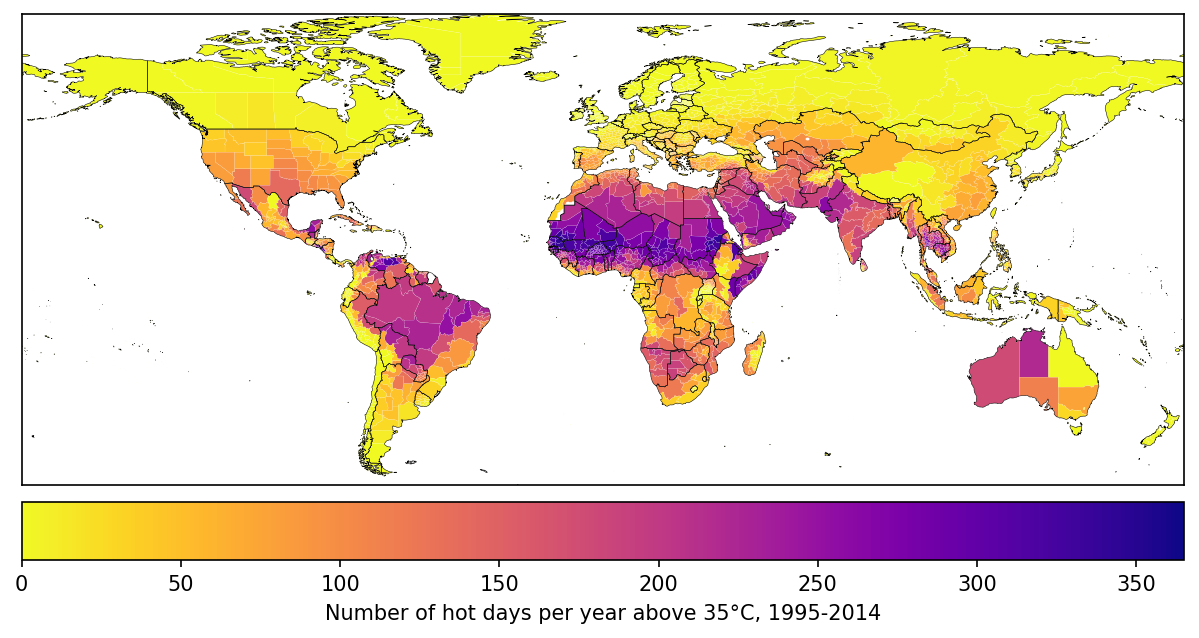

In [6]:
# Gráfica subnacional de Banco Mundial.
# Number of hot days per year above 35°C, 1995-2014

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Graficamos datos
gdf_sub.plot( ax = ax, column = v,  edgecolor = "white", linewidth = 0.05,
    cmap = "plasma_r", legend = True,
    vmin = 0, vmax = 365,
    #vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {
    "label": "Number of hot days per year above 35°C, 1995-2014",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"}
    )

# Graficamos países
gdf0_50[ ~(gdf0_50.index == "ATA") ].boundary.plot(
    ax = ax, edgecolor = "black", linewidth = 0.25)

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

In [7]:
# Cargamos los datos del World Bank y los unimos a un mapa
# Number of hot days per year above 35°C, 2080-2099, RCP8.5

# Variable a estudiar
v = "h35_2090_rcp85"
# Número de archivo correspondiente
i = 0 # Histórico

# Lista de archivos del World Bank
wb_f = os.listdir(wb_path)
# Los datos se descargan en un Excel
wb_h = pd.read_excel(wb_path + wb_f[i], index_col = "code" )
# Cargamos la relación de códigos.
code_wb = pd.read_csv(code_path, index_col = "code" )
# Usamos solo los datos de los códigos de la relación
# Quitamos datos subnacionales que no tenemos
wb_h = wb_h.loc[ code_wb.index ]

# Agregamos código, país, y nombre según Natural Earth
wb_h[ix1] = code_wb[ix1]
wb_h["country"] = code_wb["adm0_a3"]
wb_h["name"] = code_wb["name_N_E"]

# Cambiamos el código de Banco Mundial a ISO
wb_h = wb_h.reset_index(drop = True).set_index(ix1)
# Cambiamos nombre de columnas
wb_h.columns = ["name", v, ix]
# Si hay varias entradas del Banco Mundial por una de Natural Earth,
# hay que promediar. Debería hacerse ponderando las áreas de las regiones
# pero en algunos casos es muy difícil de obtener esa información
values = wb_h[v].groupby("iso_3166_2").mean()
wb_h = wb_h[ ~wb_h.index.duplicated(keep = "first") ].sort_index()

# Escogemos las geometrías subnacionales y nacionales que correspondan
sub_iso0 = wb_h[ ~wb_h.index.isin(gdf1_mod.index) ].index
sub_iso1 = wb_h[ wb_h.index.isin(gdf1_mod.index) ].index
gdf_sub_iso0 = gdf0_10[ gdf0_10.index.isin(sub_iso0) ][
    ["NAME", "geometry"] ].rename( columns = {"NAME": "name"} )
gdf_sub_iso1 = gdf1_mod[ gdf1_mod.index.isin(sub_iso1) ][["name", "geometry"]]
gdf_sub = pd.concat( [gdf_sub_iso0, gdf_sub_iso1] )

# Unimos las geometrías y los datos. Si hay un dato de World Bank para
# varios de Natural Earth se asigna el mismo valor a todas las geometrías
gdf_sub = gdf_sub.join(wb_h[v])

KeyError: "['SOM.2262688', 'SOM.2262702', 'SOM.2262703', 'SOM.2262704', 'SOM.2262705', 'AND.7392', 'AND.7393', 'AND.7395', 'AND.7396', 'AND.7397', 'AND.7391', 'AND.7394', 'ARE.255149626', 'ARE.2553173', 'ARE.2553177', 'ARE.255149627', 'ARE.2553179', 'ARE.2553180', 'ARE.2553181', 'AFG.14', 'AFG.15', 'AFG.12', 'AFG.11', 'AFG.13', 'AFG.17', 'AFG.18', 'AFG.19', 'AFG.110', 'AFG.111', 'AFG.112', 'AFG.113', 'AFG.114', 'AFG.115', 'AFG.116', 'AFG.119', 'AFG.117', 'AFG.118', 'AFG.120', 'AFG.121', 'AFG.122', 'AFG.123', 'AFG.124', 'AFG.127', 'AFG.128', 'AFG.125', 'AFG.126', 'AFG.129', 'AFG.130', 'AFG.131', 'AFG.16', 'AFG.132', 'AFG.133', 'AFG.134', 'ATG.1140208', 'ATG.1140209', 'ATG.1140210', 'ATG.1140211', 'ATG.1140212', 'ATG.1140213', 'ATG.1140206', 'ATG.1140207', 'ALB.3305', 'ALB.3320', 'ALB.3336', 'ALB.3310', 'ALB.3319', 'ALB.3311', 'ALB.3314', 'ALB.3324', 'ALB.3330', 'ALB.3312', 'ALB.3325', 'ALB.3327', 'ALB.3313', 'ALB.3331', 'ALB.3337', 'ALB.3308', 'ALB.3317', 'ALB.3318', 'ALB.3332', 'ALB.3315', 'ALB.3321', 'ALB.3339', 'ALB.3322', 'ALB.3323', 'ALB.3329', 'ALB.3306', 'ALB.3309', 'ALB.3328', 'ALB.3326', 'ALB.3333', 'ALB.3335', 'ALB.3316', 'ALB.3338', 'ALB.3307', 'ALB.3334', 'ALB.3340', 'ARM.13453', 'ARM.13454', 'ARM.13455', 'ARM.13464', 'ARM.13456', 'ARM.13457', 'ARM.13458', 'ARM.13460', 'ARM.13461', 'ARM.13462', 'ARM.13463', 'AGO.8398', 'AGO.8399', 'AGO.8400', 'AGO.8401', 'AGO.8402', 'AGO.8404', 'AGO.8407', 'AGO.8403', 'AGO.8405', 'AGO.8406', 'AGO.8409', 'AGO.8410', 'AGO.8408', 'AGO.8411', 'AGO.8412', 'AGO.8413', 'AGO.8414', 'AGO.8415', 'ARG.12445', 'ARG.12429', 'ARG.12430', 'ARG.12447', 'ARG.12436', 'ARG.12440', 'ARG.12450', 'ARG.12432', 'ARG.12446', 'ARG.12431', 'ARG.12439', 'ARG.12441', 'ARG.12442', 'ARG.12437', 'ARG.12443', 'ARG.12444', 'ARG.12449', 'ARG.12452', 'ARG.12433', 'ARG.12451', 'ARG.12435', 'ARG.12434', 'ARG.12438', 'ARG.12448', 'AUT.18478', 'AUT.18479', 'AUT.18480', 'AUT.18481', 'AUT.18482', 'AUT.18483', 'AUT.18484', 'AUT.18485', 'AUT.18486', 'AUS.17468', 'AUS.17470', 'AUS.17471', 'AUS.17469', 'AUS.17473', 'AUS.17474', 'AUS.17475', 'AUS.17476', 'AUS.17477', 'AZE.19147297', 'AZE.19147300', 'AZE.19147298', 'AZE.19147306', 'AZE.19147299', 'AZE.19147303', 'AZE.19147304', 'AZE.19147305', 'AZE.19147302', 'AZE.19147301', 'BIH.34652', 'BIH.34653', 'BRB.24581', 'BRB.24582', 'BRB.24583', 'BRB.24584', 'BRB.24585', 'BRB.24586', 'BRB.24587', 'BRB.24588', 'BRB.24589', 'BRB.24590', 'BRB.24591', 'BGD.231', 'BGD.232', 'BGD.233', 'BGD.235', 'BGD.234', 'BGD.236', 'BGD.237', 'BGD.238', 'BEL.27600', 'BEL.27601', 'BEL.27602', 'BFA.4240276', 'BFA.4240280', 'BFA.4240282', 'BFA.4240288', 'BFA.4240279', 'BFA.4240281', 'BFA.4240277', 'BFA.4240286', 'BFA.4240283', 'BFA.4240284', 'BFA.4240278', 'BFA.4240285', 'BFA.4240287', 'BGR.41702', 'BGR.41703', 'BGR.41726', 'BGR.41727', 'BGR.41728', 'BGR.41729', 'BGR.41705', 'BGR.41704', 'BGR.41708', 'BGR.41709', 'BGR.41710', 'BGR.41711', 'BGR.41712', 'BGR.41713', 'BGR.41714', 'BGR.41715', 'BGR.41716', 'BGR.41717', 'BGR.41719', 'BGR.41720', 'BGR.41721', 'BGR.41723', 'BGR.41722', 'BGR.41724', 'BGR.41725', 'BGR.41706', 'BGR.41718', 'BGR.41707', 'BHR.21568', 'BHR.21572', 'BHR.21564', 'BHR.21571', 'BHR.21573', 'BHR.21565', 'BHR.21569', 'BHR.21562', 'BHR.21566', 'BHR.21563', 'BHR.21567', 'BHR.21570', 'BDI.4340542', 'BDI.4340544', 'BDI.4340543', 'BDI.4340545', 'BDI.4340546', 'BDI.4340547', 'BDI.4340548', 'BDI.4340551', 'BDI.4340549', 'BDI.4340550', 'BDI.4340552', 'BDI.4340553', 'BDI.4340555', 'BDI.4340554', 'BDI.4340556', 'BDI.4340557', 'BDI.4340558', 'BEN.29610', 'BEN.29609', 'BEN.29611', 'BEN.29612', 'BEN.29613', 'BEN.29615', 'BEN.29614', 'BEN.29616', 'BEN.29617', 'BEN.29618', 'BEN.29619', 'BEN.29620', 'BRN.40698', 'BRN.40699', 'BRN.40700', 'BRN.40701', 'BOL.3340443', 'BOL.3340445', 'BOL.3340444', 'BOL.3340446', 'BOL.33648', 'BOL.3340447', 'BOL.3340448', 'BOL.3340449', 'BOL.3340450', 'BRA.37665', 'BRA.37666', 'BRA.37668', 'BRA.37667', 'BRA.37669', 'BRA.37670', 'BRA.37671', 'BRA.37672', 'BRA.37673', 'BRA.37674', 'BRA.37677', 'BRA.37676', 'BRA.37675', 'BRA.37678', 'BRA.37679', 'BRA.37681', 'BRA.37682', 'BRA.37680', 'BRA.37683', 'BRA.37684', 'BRA.37686', 'BRA.37687', 'BRA.37685', 'BRA.37688', 'BRA.37690', 'BRA.37689', 'BRA.37691', 'BTN.31629', 'BTN.31623', 'BTN.3141309', 'BTN.3141312', 'BTN.31635', 'BTN.31639', 'BTN.3141308', 'BTN.31631', 'BTN.31640', 'BTN.3141313', 'BTN.31638', 'BTN.31622', 'BTN.3141314', 'BTN.31637', 'BTN.31628', 'BTN.3141310', 'BTN.31627', 'BTN.3141311', 'BTN.31625', 'BTN.31636', 'BWA.35654', 'BWA.35656', 'BWA.35657', 'BWA.35658', 'BWA.35659', 'BWA.35662', 'BWA.35661', 'BWA.35655', 'BWA.35660', 'BWA.35663', 'BLR.26593', 'BLR.26597', 'BLR.26594', 'BLR.26595', 'BLR.26598', 'BLR.26596', 'BLR.26599', 'BLZ.28603', 'BLZ.28604', 'BLZ.28605', 'BLZ.28606', 'BLZ.28607', 'BLZ.28608', 'CAN.461', 'CAN.462', 'CAN.463', 'CAN.464', 'CAN.465', 'CAN.467', 'CAN.466', 'CAN.468', 'CAN.469', 'CAN.4610', 'CAN.4611', 'CAN.4612', 'CAN.4613', 'COD.681069', 'COD.681066', 'COD.681067', 'COD.681068', 'COD.681070', 'COD.681071', 'COD.681072', 'COD.681073', 'COD.681074', 'COD.681080', 'COD.681081', 'COD.681082', 'COD.681083', 'COD.681079', 'COD.681077', 'COD.681078', 'COD.681084', 'COD.681075', 'COD.681076', 'COD.681085', 'COD.681086', 'COD.681087', 'COD.681088', 'COD.681089', 'COD.681090', 'COD.681091', 'CAF.49865', 'CAF.49853', 'CAF.4967154', 'CAF.49854', 'CAF.49856', 'CAF.49855', 'CAF.49859', 'CAF.49861', 'CAF.49857', 'CAF.49858', 'CAF.49860', 'CAF.49863', 'CAF.49862', 'CAF.49866', 'CAF.49867', 'CAF.49864', 'CAF.49868', 'COG.59970', 'COG.59190431', 'COG.59979', 'COG.59977', 'COG.59972', 'COG.59190434', 'COG.59974', 'COG.59190433', 'COG.59975', 'COG.59971', 'COG.59976', 'COG.59190432', 'CHE.2372807', 'CHE.2372809', 'CHE.2372808', 'CHE.2372812', 'CHE.2372810', 'CHE.2372811', 'CHE.2372813', 'CHE.2372814', 'CHE.2372815', 'CHE.2372816', 'CHE.2372817', 'CHE.2372818', 'CHE.2372819', 'CHE.2372820', 'CHE.2372821', 'CHE.2372822', 'CHE.2372823', 'CHE.2372825', 'CHE.2372824', 'CHE.2372826', 'CHE.2372827', 'CHE.2372828', 'CHE.2372830', 'CHE.2372829', 'CHE.2372831', 'CHE.2372832', 'CIV.661', 'CIV.669', 'CIV.6610', 'CIV.6611', 'CIV.663', 'CIV.668', 'CIV.666', 'CIV.6613', 'CIV.6614', 'CIV.662', 'CIV.664', 'CIV.6612', 'CIV.665', 'CIV.667', 'CHL.51886', 'CHL.51883', 'CHL.5191503', 'CHL.51884', 'CHL.51885', 'CHL.51887', 'CHL.51888', 'CHL.51889', 'CHL.5191501', 'CHL.5191504', 'CHL.51891', 'CHL.51892', 'CHL.51893', 'CHL.5191502', 'CHL.51149630', 'CMR.45815', 'CMR.45816', 'CMR.45818', 'CMR.45817', 'CMR.45819', 'CMR.45820', 'CMR.45821', 'CMR.45822', 'CMR.45823', 'CMR.45824', 'CHN.147295898', 'CHN.147295899', 'CHN.147295900', 'CHN.147295901', 'CHN.147295903', 'CHN.147295902', 'CHN.147295904', 'CHN.147295905', 'CHN.147295909', 'CHN.147295911', 'CHN.147295907', 'CHN.147295906', 'CHN.147295908', 'CHN.147295912', 'CHN.147295915', 'CHN.147295913', 'CHN.147295914', 'CHN.147295916', 'CHN.147295917', 'CHN.147295918', 'CHN.147295919', 'CHN.147295924', 'CHN.147295921', 'CHN.147295922', 'CHN.147295920', 'CHN.147295923', 'CHN.147295926', 'CHN.147295927', 'CHN.147295928', 'CHN.147295929', 'CHN.147295930', 'COL.57934', 'COL.57935', 'COL.57936', 'COL.57937', 'COL.57938', 'COL.57939', 'COL.57941', 'COL.57942', 'COL.57943', 'COL.57944', 'COL.57945', 'COL.57946', 'COL.57947', 'COL.579481', 'COL.57948', 'COL.57949', 'COL.57951', 'COL.57952', 'COL.57950', 'COL.57953', 'COL.57954', 'COL.57955', 'COL.57956', 'COL.57957', 'COL.57958', 'COL.57959', 'COL.57961', 'COL.57960', 'COL.57962', 'COL.57963', 'COL.57964', 'COL.57965', 'COL.57966', 'CRI.61981', 'CRI.61982', 'CRI.61983', 'CRI.61984', 'CRI.61985', 'CRI.61986', 'CRI.61987', 'CUB.631020', 'CUB.631012', 'CUB.631019', 'CUB.631023', 'CUB.631011', 'CUB.631021', 'CUB.631010', 'CUB.631009', 'CUB.631018', 'CUB.631015', 'CUB.631013', 'CUB.631022', 'CUB.631014', 'CUB.631017', 'CUB.631016', 'CPV.47839', 'CPV.47838', 'CPV.47848', 'CPV.47841', 'CPV.47844', 'CPV.47849', 'CPV.47850', 'CPV.47846', 'CPV.47851', 'CYP.6475406', 'CYP.6475405', 'CYP.6475404', 'CYP.6475403', 'CYP.6475401', 'CYP.6475407', 'CZE.651030', 'CZE.651031', 'CZE.651037', 'CZE.651036', 'CZE.651033', 'CZE.651034', 'CZE.651032', 'CZE.651035', 'DEU.931311', 'DEU.931310', 'DEU.931308', 'DEU.931309', 'DEU.931312', 'DEU.931314', 'DEU.931313', 'DEU.931315', 'DEU.931316', 'DEU.931317', 'DEU.931318', 'DEU.931322', 'DEU.931319', 'DEU.931320', 'DEU.931321', 'DEU.931323', 'DJI.703', 'DJI.705', 'DJI.704', 'DJI.701', 'DJI.702', 'DNK.693', 'DNK.692', 'DNK.694', 'DNK.691', 'DNK.695', 'DMA.711098', 'DMA.711099', 'DMA.711100', 'DMA.711101', 'DMA.711102', 'DMA.711103', 'DMA.711104', 'DMA.711105', 'DMA.711106', 'DMA.711107', 'DOM.7236858', 'DOM.721108', 'DOM.721109', 'DOM.721110', 'DOM.721111', 'DOM.721113', 'DOM.721118', 'DOM.721114', 'DOM.721115', 'DOM.721116', 'DOM.721117', 'DOM.721119', 'DOM.721120', 'DOM.721121', 'DOM.721122', 'DOM.721123', 'DOM.721124', 'DOM.721125', 'DOM.721126', 'DOM.721127', 'DOM.721128', 'DOM.721129', 'DOM.721130', 'DOM.721131', 'DOM.721132', 'DOM.721133', 'DOM.721134', 'DOM.7236855', 'DOM.7236856', 'DOM.7236854', 'DOM.7236857', 'DOM.721112', 'DZA.4341', 'DZA.4354', 'DZA.4365', 'DZA.4374', 'DZA.4346', 'DZA.4348', 'DZA.4349', 'DZA.4347', 'DZA.4350', 'DZA.4352', 'DZA.4381', 'DZA.4382', 'DZA.4388', 'DZA.4384', 'DZA.4387', 'DZA.4344', 'DZA.4356', 'DZA.4363', 'DZA.4377', 'DZA.4376', 'DZA.4379', 'DZA.4378', 'DZA.4345', 'DZA.4361', 'DZA.4355', 'DZA.4367', 'DZA.4369', 'DZA.4370', 'DZA.4366', 'DZA.4373', 'DZA.4372', 'DZA.4357', 'DZA.4362', 'DZA.4351', 'DZA.4353', 'DZA.4359', 'DZA.4383', 'DZA.4386', 'DZA.4358', 'DZA.4364', 'DZA.4380', 'DZA.4385', 'DZA.4368', 'DZA.4342', 'DZA.4371', 'DZA.4343', 'DZA.4360', 'DZA.4375', 'ECU.731135', 'ECU.731136', 'ECU.731138', 'ECU.731151', 'ECU.731142', 'ECU.731137', 'ECU.7322005', 'ECU.731139', 'ECU.731145', 'ECU.731146', 'ECU.731148', 'ECU.731150', 'ECU.731141', 'ECU.7322006', 'ECU.731147', 'ECU.731149', 'ECU.7322008', 'ECU.7322007', 'ECU.731155', 'ECU.731154', 'ECU.731143', 'ECU.731140', 'ECU.731152', 'ECU.731156', 'EST.781212', 'EST.781213', 'EST.781214', 'EST.781216', 'EST.781215', 'EST.781218', 'EST.781217', 'EST.781220', 'EST.781219', 'EST.781221', 'EST.781222', 'EST.781223', 'EST.781224', 'EST.781225', 'EST.781226', 'EGY.4076561510', 'EGY.4076561512', 'EGY.4076561511', 'EGY.4076561532', 'EGY.4076561513', 'EGY.4076561514', 'EGY.4076561515', 'EGY.4076561516', 'EGY.4076561517', 'EGY.4076561518', 'EGY.4076561519', 'EGY.4076561520', 'EGY.4076561521', 'EGY.4076561534', 'EGY.4076561523', 'EGY.4076561522', 'EGY.4076561531', 'EGY.4076561524', 'EGY.4076561526', 'EGY.4076561527', 'EGY.4076561525', 'EGY.4076561530', 'EGY.4076561536', 'EGY.4076561533', 'EGY.4076561529', 'EGY.4076561535', 'EGY.4076561528', 'ERI.771205', 'ERI.771208', 'ERI.771207', 'ERI.771209', 'ERI.771210', 'ERI.771206', 'ERI.771211', 'ESP.2292726', 'ESP.2292723', 'ESP.2292716', 'ESP.2292722', 'ESP.2292724', 'ESP.2292727', 'ESP.2292733', 'ESP.2292728', 'ESP.2292725', 'ESP.2292720', 'ESP.2292717', 'ESP.2292734', 'ESP.2292729', 'ESP.2292730', 'ESP.2292731', 'ESP.2292732', 'ESP.2292718', 'ESP.2292719', 'ESP.2292721', 'ETH.791', 'ETH.792', 'ETH.793', 'ETH.794', 'ETH.795', 'ETH.796', 'ETH.797', 'ETH.798', 'ETH.799', 'ETH.7910', 'ETH.7911', 'ETH.7912', 'FIN.841246', 'FIN.841247', 'FIN.841243', 'FIN.841245', 'FIN.841244', 'FJI.8340187', 'FJI.8340188', 'FJI.8340189', 'FJI.8340190', 'FRA.851270', 'FRA.851267', 'FRA.851250', 'FRA.851269', 'FRA.851255', 'FRA.851264', 'FRA.851260', 'FRA.851251', 'FRA.851268', 'FRA.851254', 'FRA.851262', 'FRA.851252', 'FRA.851253', 'FRA.851249', 'FRA.851257', 'FRA.851258', 'FRA.851256', 'FRA.851266', 'FRA.851263', 'FRA.851265', 'FRA.851248', 'FRA.851259', 'GAB.891275', 'GAB.891276', 'GAB.891277', 'GAB.891278', 'GAB.891279', 'GAB.891280', 'GAB.891281', 'GAB.891282', 'GAB.891283', 'GBR.2563184', 'GBR.2563186', 'GBR.2563183', 'GBR.2563182', 'GRD.991353', 'GRD.991352', 'GRD.991354', 'GRD.991355', 'GRD.991356', 'GRD.991357', 'GRD.9975500', 'GEO.921296', 'GEO.921297', 'GEO.921298', 'GEO.921299', 'GEO.921300', 'GEO.921301', 'GEO.921302', 'GEO.921303', 'GEO.921305', 'GEO.921306', 'GEO.921304', 'GEO.921307', 'GHA.941328', 'GHA.941324', 'GHA.943', 'GHA.944', 'GHA.941325', 'GHA.941326', 'GHA.941327', 'GHA.941', 'GHA.941329', 'GHA.942', 'GHA.945', 'GHA.941332', 'GHA.941330', 'GHA.941331', 'GHA.941333', 'GHA.946', 'GRL.981351', 'GRL.981349', 'GRL.981350', 'GLP.100100', 'GMB.90112869', 'GMB.901287', 'GMB.901285', 'GMB.901288', 'GMB.901289', 'GMB.901290', 'GIN.10640707', 'GIN.10640700', 'GIN.10640701', 'GIN.10640704', 'GIN.10640702', 'GIN.10640706', 'GIN.10640703', 'GIN.10640705', 'GNQ.761198', 'GNQ.761199', 'GNQ.761200', 'GNQ.761201', 'GNQ.761202', 'GNQ.761203', 'GNQ.761204', 'GRC.971342', 'GRC.971336', 'GRC.971337', 'GRC.971339', 'GRC.971341', 'GRC.971347', 'GRC.971340', 'GRC.971338', 'GRC.971346', 'GRC.971345', 'GRC.971348', 'GRC.9740766', 'GRC.971343', 'GTM.10364836', 'GTM.10364835', 'GTM.10364824', 'GTM.10364840', 'GTM.10364825', 'GTM.10364821', 'GTM.10364833', 'GTM.10364838', 'GTM.10364841', 'GTM.10364842', 'GTM.10364837', 'GTM.10364822', 'GTM.10364834', 'GTM.10364829', 'GTM.10364831', 'GTM.10364823', 'GTM.10364832', 'GTM.10364827', 'GTM.10364826', 'GTM.10364830', 'GTM.10364828', 'GTM.10364839', 'GNB.1051385', 'GNB.1051387', 'GNB.1051386', 'GNB.1051392', 'GNB.1051388', 'GNB.1051389', 'GNB.1051390', 'GNB.1051391', 'GNB.1051393', 'GUY.1071398', 'GUY.1071399', 'GUY.1071400', 'GUY.1071401', 'GUY.1071402', 'GUY.1071403', 'GUY.1071404', 'GUY.1071405', 'GUY.1071406', 'GUY.1071407', 'HND.1111420', 'HND.1111421', 'HND.1111422', 'HND.1111423', 'HND.1111424', 'HND.1111425', 'HND.1111435', 'HND.1111426', 'HND.1111427', 'HND.1111429', 'HND.1111428', 'HND.1111431', 'HND.1111430', 'HND.1111433', 'HND.1111434', 'HND.1111436', 'HND.1111437', 'HND.1111438', 'HRV.621008', 'HRV.62994', 'HRV.621001', 'HRV.62992', 'HRV.621004', 'HRV.62993', 'HRV.62988', 'HRV.62999', 'HRV.62995', 'HRV.621005', 'HRV.62998', 'HRV.621002', 'HRV.621007', 'HRV.62997', 'HRV.621000', 'HRV.621006', 'HRV.621003', 'HRV.62991', 'HRV.62989', 'HRV.62996', 'HRV.62990', 'HTI.1081', 'HTI.1082', 'HTI.1083', 'HTI.1085', 'HTI.1086', 'HTI.1084', 'HTI.1087', 'HTI.10810', 'HTI.1088', 'HTI.1089', 'HUN.1131441', 'HUN.1131442', 'HUN.1131440', 'HUN.1131444', 'HUN.1131443', 'HUN.1131445', 'HUN.1131448', 'HUN.1131446', 'HUN.1131453', 'HUN.1131449', 'HUN.1131447', 'HUN.1131450', 'HUN.1131451', 'HUN.1131454', 'HUN.1131459', 'HUN.1131452', 'HUN.1131455', 'HUN.1131457', 'HUN.1131456', 'HUN.1131458', 'IDN.1161512', 'IDN.1161513', 'IDN.11673609', 'IDN.1161514', 'IDN.11673610', 'IDN.11673611', 'IDN.1161518', 'IDN.11673613', 'IDN.1161521', 'IDN.1161516', 'IDN.1161520', 'IDN.1161522', 'IDN.1161525', 'IDN.11673614', 'IDN.1161523', 'IDN.1161524', 'IDN.1161526', 'IDN.11673615', 'IDN.11673616', 'IDN.1161528', 'IDN.1161529', 'IDN.11673617', 'IDN.11673612', 'IDN.11673618', 'IDN.11673621', 'IDN.1161535', 'IDN.1161533', 'IDN.11673620', 'IDN.11673619', 'IDN.11673622', 'IDN.1161532', 'IDN.1161537', 'IDN.1161515', 'IRL.1191584', 'IRL.1191583', 'IRL.1191585', 'IRL.1191582', 'IRL.1191587', 'IRL.1191586', 'IRL.1191588', 'IRL.1191590', 'IRL.1191591', 'IRL.1191589', 'IRL.1191595', 'IRL.1191596', 'IRL.1191594', 'IRL.1191593', 'IRL.1191592', 'IRL.1191598', 'IRL.1191599', 'IRL.1191597', 'IRL.1191601', 'IRL.1191602', 'IRL.1191603', 'IRL.1191604', 'IRL.1191605', 'IRL.1191606', 'IRL.1191608', 'IRL.1191607', 'ISR.1211613', 'ISR.1211611', 'ISR.1211612', 'ISR.1211610', 'ISR.1211615', 'ISR.1211614', 'IND.1151', 'IND.1152', 'IND.1153', 'IND.1154', 'IND.1155', 'IND.1156', 'IND.1157', 'IND.1158', 'IND.1159', 'IND.11510', 'IND.11511', 'IND.11512', 'IND.11514', 'IND.11513', 'IND.11516', 'IND.11515', 'IND.11517', 'IND.11518', 'IND.11519', 'IND.11521', 'IND.11523', 'IND.11522', 'IND.11520', 'IND.11524', 'IND.11525', 'IND.11526', 'IND.11528', 'IND.11527', 'IND.11529', 'IND.11530', 'IND.11532', 'IND.11531', 'IND.11533', 'IND.11534', 'IND.11535', 'IND.11536', 'IRQ.1182', 'IRQ.1181', 'IRQ.1183', 'IRQ.1188', 'IRQ.1189', 'IRQ.11810', 'IRQ.11811', 'IRQ.11812', 'IRQ.11814', 'IRQ.11816', 'IRQ.1186', 'IRQ.1187', 'IRQ.11817', 'IRQ.1185', 'IRQ.11813', 'IRQ.1184', 'IRQ.11815', 'IRQ.11818', 'IRN.1171542', 'IRN.1171561', 'IRN.11733110', 'IRN.1171543', 'IRN.1171549', 'IRN.1171540', 'IRN.1171560', 'IRN.1171541', 'IRN.1171551', 'IRN.1171563', 'IRN.1171558', 'IRN.1171559', 'IRN.1171544', 'IRN.1171550', 'IRN.1171553', 'IRN.1171539', 'IRN.1171552', 'IRN.1171545', 'IRN.1171555', 'IRN.1171557', 'IRN.1171556', 'IRN.1171548', 'IRN.1171546', 'IRN.1171562', 'IRN.11733113', 'IRN.11733111', 'IRN.11733112', 'IRN.1171547', 'ISL.1141468', 'ISL.1141467', 'ISL.1141464', 'ISL.1141465', 'ISL.1141469', 'ISL.1141476', 'ISL.1141461', 'ISL.1141471', 'ISL.1141477', 'ISL.1141480', 'ISL.1141482', 'ISL.1141462', 'ISL.1141475', 'ISL.1141481', 'ISL.1141466', 'ISL.1141473', 'ISL.1141479', 'ISL.1141463', 'ISL.1141472', 'ISL.1141478', 'ISL.1141460', 'ISL.1141474', 'ISL.1141483', 'ITA.1221630', 'ITA.1221627', 'ITA.1221625', 'ITA.1221634', 'ITA.1221616', 'ITA.1221631', 'ITA.1221619', 'ITA.1221628', 'ITA.1221624', 'ITA.1221635', 'ITA.1221620', 'ITA.1221632', 'ITA.1221629', 'ITA.1221626', 'ITA.1221618', 'ITA.1221622', 'ITA.1221623', 'ITA.1221621', 'ITA.1221617', 'ITA.1221633', 'JAM.1231640', 'JAM.1231646', 'JAM.1231639', 'JAM.1231645', 'JAM.1231641', 'JAM.1231647', 'JAM.1231644', 'JAM.1231637', 'JAM.1231648', 'JAM.1231643', 'JAM.1231638', 'JAM.1231636', 'JAM.1231642', 'JOR.1301701', 'JOR.1301705', 'JOR.1301703', 'JOR.1301706', 'JOR.1301712', 'JOR.1301702', 'JOR.1301707', 'JOR.1301708', 'JOR.1301704', 'JOR.1301711', 'JOR.1301710', 'JOR.1301709', 'JPN.1261661', 'JPN.1261653', 'JPN.1261665', 'JPN.1261673', 'JPN.1261652', 'JPN.1261695', 'JPN.1261657', 'JPN.1261663', 'JPN.1261688', 'JPN.1261659', 'JPN.1261684', 'JPN.1261693', 'JPN.1261690', 'JPN.1261668', 'JPN.1261678', 'JPN.1261692', 'JPN.1261664', 'JPN.1261655', 'JPN.1261697', 'JPN.1261675', 'JPN.1261658', 'JPN.1261687', 'JPN.1261651', 'JPN.1261672', 'JPN.1261685', 'JPN.1261671', 'JPN.1261682', 'JPN.1261662', 'JPN.1261677', 'JPN.1261694', 'JPN.1261691', 'JPN.1261686', 'JPN.1261680', 'JPN.1261660', 'JPN.1261696', 'JPN.1261689', 'JPN.1261666', 'JPN.1261654', 'JPN.1261669', 'JPN.1261656', 'JPN.1261683', 'JPN.1261676', 'JPN.1261670', 'JPN.1261679', 'JPN.1261674', 'JPN.1261667', 'JPN.1261681', 'KEN.13320', 'KEN.13327', 'KEN.13328', 'KEN.13326', 'KEN.13338', 'KEN.13336', 'KEN.13325', 'KEN.13337', 'KEN.13343', 'KEN.13318', 'KEN.13346', 'KEN.13315', 'KEN.13324', 'KEN.13330', 'KEN.13340', 'KEN.13334', 'KEN.13332', 'KEN.13342', 'KEN.13317', 'KEN.13345', 'KEN.1337', 'KEN.1338', 'KEN.13322', 'KEN.13329', 'KEN.13310', 'KEN.13339', 'KEN.1335', 'KEN.13312', 'KEN.1334', 'KEN.1339', 'KEN.13311', 'KEN.13335', 'KEN.13333', 'KEN.1332', 'KEN.13341', 'KEN.1336', 'KEN.1333', 'KEN.13323', 'KEN.13347', 'KEN.13319', 'KEN.13344', 'KEN.1331', 'KEN.13331', 'KEN.13314', 'KEN.13313', 'KEN.13316', 'KEN.13321', 'KGZ.1381746', 'KGZ.138147294', 'KGZ.1381748', 'KGZ.1381749', 'KGZ.1381750', 'KGZ.1381751', 'KGZ.1381752', 'KHM.44791', 'KHM.44801', 'KHM.44803', 'KHM.44806', 'KHM.44807', 'KHM.44808', 'KHM.44809', 'KHM.44810', 'KHM.44811', 'KHM.44802', 'KHM.44812', 'KHM.44792', 'KHM.44813', 'KHM.44814', 'KHM.44804', 'KHM.44800', 'KHM.44805', 'KHM.447931', 'KHM.44793', 'KHM.44794', 'KHM.44795', 'KHM.44796', 'KHM.44797', 'KHM.44798', 'KHM.44799', 'COM.58967', 'COM.58969', 'COM.58968', 'KNA.2082593', 'KNA.2082594', 'KNA.2082595', 'KNA.2082596', 'KNA.2082597', 'KNA.2082598', 'KNA.2082599', 'KNA.2082600', 'KNA.2082601', 'KNA.2082602', 'KNA.2082603', 'KNA.2082604', 'KNA.2082605', 'KNA.2082606', 'PRK.671061', 'PRK.671064', 'PRK.671060', 'PRK.671054', 'PRK.671063', 'PRK.671059', 'PRK.671056', 'PRK.671062', 'PRK.671058', 'PRK.671065', 'PRK.671055', 'KOR.2022443', 'KOR.2022442', 'KOR.2022444', 'KOR.2022436', 'KOR.2022438', 'KOR.2022445', 'KOR.2022440', 'KOR.2022439', 'KOR.2022437', 'KOR.2022434', 'KOR.2022435', 'KOR.2022432', 'KOR.2022433', 'KOR.2022441', 'KOR.2022431', 'KWT.1371742', 'KWT.1371741', 'KWT.1371745', 'KWT.1371743', 'KWT.1371744', 'KAZ.1321714', 'KAZ.1321715', 'KAZ.1321716', 'KAZ.13237157', 'KAZ.1321717', 'KAZ.1321719', 'KAZ.1321720', 'KAZ.1321721', 'KAZ.1321724', 'KAZ.1321725', 'KAZ.1321726', 'KAZ.1321727', 'KAZ.1321728', 'KAZ.1321729', 'KAZ.1321718', 'LAO.1391', 'LAO.1392', 'LAO.1393', 'LAO.1394', 'LAO.1395', 'LAO.1396', 'LAO.1397', 'LAO.1398', 'LAO.1399', 'LAO.13910', 'LAO.13911', 'LAO.13912', 'LAO.13913', 'LAO.13914', 'LAO.13916', 'LAO.13915', 'LAO.13917', 'LAO.13918', 'LBN.1411799', 'LBN.14117991', 'LBN.1411798', 'LBN.1411797', 'LBN.14117971', 'LBN.1411800', 'LBN.1411801', 'LBN.1411802', 'LIE.1461854', 'LIE.1461855', 'LIE.1461856', 'LIE.1461857', 'LIE.1461859', 'LIE.1461860', 'LIE.1461861', 'LIE.1461862', 'LIE.1461863', 'LIE.1461864', 'LIE.1461865', 'LKA.2312744', 'LKA.2312736', 'LKA.2312742', 'LKA.2312740', 'LKA.2312737', 'LKA.2312739', 'LKA.2312738', 'LKA.2312743', 'LKA.2312741', 'LBR.1442', 'LBR.1441', 'LBR.1445', 'LBR.1444', 'LBR.1446', 'LBR.1447', 'LBR.1448', 'LBR.1449', 'LBR.14411', 'LBR.14410', 'LBR.14412', 'LBR.14414', 'LBR.14415', 'LBR.1443', 'LBR.14413', 'LSO.1421807', 'LSO.1421804', 'LSO.1421805', 'LSO.1421803', 'LSO.1421806', 'LSO.1421808', 'LSO.1421811', 'LSO.1421810', 'LSO.1421809', 'LSO.1421812', 'LTU.1471866', 'LTU.1471868', 'LTU.1471867', 'LTU.1471869', 'LTU.1471870', 'LTU.1471871', 'LTU.1471872', 'LTU.1471873', 'LTU.1471874', 'LTU.1471875', 'LUX.1481876', 'LUX.1481877', 'LUX.1481878', 'LVA.1402', 'LVA.1403', 'LVA.1404', 'LVA.1405', 'LVA.1406', 'LVA.1407', 'LVA.1408', 'LVA.1409', 'LVA.14010', 'LVA.14011', 'LVA.1401', 'LVA.14012', 'LVA.14013', 'LVA.14014', 'LVA.14015', 'LVA.14016', 'LVA.14017', 'LVA.14018', 'LVA.14019', 'LVA.14020', 'LVA.14022', 'LVA.14021', 'LVA.14023', 'LVA.14024', 'LVA.14027', 'LVA.14028', 'LVA.14029', 'LVA.14030', 'LVA.14031', 'LVA.14032', 'LVA.14033', 'LVA.14034', 'LVA.14035', 'LVA.14036', 'LVA.14037', 'LVA.14038', 'LVA.14039', 'LVA.14040', 'LVA.14041', 'LVA.14047', 'LVA.14048', 'LVA.14051', 'LVA.14052', 'LVA.14053', 'LVA.14054', 'LVA.14055', 'LVA.14056', 'LVA.14049', 'LVA.14050', 'LVA.14057', 'LVA.14060', 'LVA.14059', 'LVA.14061', 'LVA.14062', 'LVA.14063', 'LVA.14064', 'LVA.14067', 'LVA.14065', 'LVA.14066', 'LVA.14068', 'LVA.14069', 'LVA.14070', 'LVA.14071', 'LVA.14072', 'LVA.14073', 'LVA.14074', 'LVA.14075', 'LVA.14076', 'LVA.14077', 'LVA.14078', 'LVA.14079', 'LVA.14080', 'LVA.14081', 'LVA.14084', 'LVA.14086', 'LVA.14087', 'LVA.14088', 'LVA.14089', 'LVA.14091', 'LVA.14090', 'LVA.14092', 'LVA.14093', 'LVA.14094', 'LVA.14095', 'LVA.14096', 'LVA.14097', 'LVA.14098', 'LVA.14099', 'LVA.140100', 'LVA.140101', 'LVA.140102', 'LVA.140103', 'LVA.140104', 'LVA.140105', 'LVA.140106', 'LVA.140107', 'LVA.140108', 'LVA.140110', 'LVA.140111', 'LVA.140112', 'LVA.140113', 'LVA.140116', 'LVA.140117', 'LVA.140118', 'LVA.140119', 'LVA.14025', 'LVA.14026', 'LVA.14044', 'LVA.14045', 'LVA.14042', 'LVA.14043', 'LVA.14046', 'LVA.14058', 'LVA.14082', 'LVA.14083', 'LVA.14085', 'LVA.140114', 'LVA.140115', 'LVA.140109', 'LBY.1451829', 'LBY.1451839', 'LBY.1451851', 'LBY.1451841', 'LBY.1451837', 'LBY.1451832', 'LBY.1451842', 'LBY.1451852', 'LBY.1451830', 'LBY.1451833', 'LBY.1451835', 'LBY.1451834', 'LBY.1451853', 'LBY.1451847', 'LBY.1451831', 'LBY.1451844', 'LBY.1451843', 'LBY.1451845', 'LBY.1451840', 'LBY.1451846', 'LBY.1451848', 'LBY.1451849', 'LBY.1451850', 'LBY.1451836', 'LBY.1451838', 'MAR.16911', 'MAR.1699', 'MAR.1696', 'MAR.1694', 'MAR.1693', 'MAR.1692', 'MAR.1698', 'MAR.1691', 'MAR.16910', 'MAR.1695', 'MAR.1697', 'MDA.2722', 'MDA.2721', 'MDA.2725', 'MDA.2723', 'MDA.2726', 'MDA.2724', 'MNE.264725350', 'MNE.264725351', 'MNE.264725352', 'MNE.264725353', 'MNE.264725354', 'MNE.264725355', 'MNE.264725356', 'MNE.264725357', 'MNE.264725358', 'MNE.264725359', 'MNE.264725360', 'MNE.264725361', 'MNE.264725362', 'MNE.264725363', 'MNE.264725364', 'MNE.264725365', 'MNE.264725366', 'MNE.264725367', 'MNE.264725368', 'MNE.264725369', 'MNE.264725370', 'MDG.15041750', 'MDG.15041753', 'MDG.15041758', 'MDG.15041762', 'MDG.15041768', 'MDG.15041751', 'MDG.15041757', 'MDG.15041763', 'MDG.15041764', 'MDG.15041771', 'MDG.15041759', 'MDG.15041760', 'MDG.15041766', 'MDG.15041769', 'MDG.15041752', 'MDG.15041761', 'MDG.15041765', 'MDG.15041770', 'MDG.15041754', 'MDG.15041755', 'MDG.15041756', 'MDG.15041767', 'MKD.2415', 'MKD.2411', 'MKD.2413', 'MKD.2416', 'MKD.2414', 'MKD.2417', 'MKD.2418', 'MKD.2412', 'MLI.1551928', 'MLI.1551930', 'MLI.1551933', 'MLI.1551932', 'MLI.1551931', 'MLI.1551934', 'MLI.1551927', 'MLI.15519271', 'MLI.1551929', 'MLI.1551926', 'MMR.17112', 'MMR.1712', 'MMR.1717', 'MMR.1718', 'MMR.17110', 'MMR.17114', 'MMR.17115', 'MMR.1711', 'MMR.1714', 'MMR.1715', 'MMR.1716', 'MMR.1713', 'MMR.1719', 'MMR.17111', 'MMR.17113', 'MNG.1672090', 'MNG.1672079', 'MNG.1672086', 'MNG.1672088', 'MNG.1672087', 'MNG.1672096', 'MNG.1672094', 'MNG.1672092', 'MNG.1672093', 'MNG.1672089', 'MNG.1672091', 'MNG.1672097', 'MNG.1672083', 'MNG.1672081', 'MNG.1672082', 'MNG.1672084', 'MNG.1672085', 'MNG.1672078', 'MNG.1672077', 'MNG.1672076', 'MNG.1672075', 'MNG.1672095', 'MRT.1592010', 'MRT.1592011', 'MRT.1592005', 'MRT.1592008', 'MRT.1592006', 'MRT.1592016', 'MRT.1592004', 'MRT.1592007', 'MRT.1592014', 'MRT.1592009', 'MRT.1592015', 'MRT.1592012', 'MRT.1592013', 'MLT.1561935', 'MLT.1561936', 'MLT.1561937', 'MLT.1561938', 'MLT.1561939', 'MLT.1561940', 'MLT.1561941', 'MLT.1561942', 'MLT.1561943', 'MLT.1561944', 'MLT.1561950', 'MLT.1561951', 'MLT.1561945', 'MLT.1561946', 'MLT.1561947', 'MLT.1561948', 'MLT.1561949', 'MLT.1561952', 'MLT.1561953', 'MLT.1561954', 'MLT.1561955', 'MLT.1561956', 'MLT.1561957', 'MLT.1561958', 'MLT.1561959', 'MLT.1561960', 'MLT.1561961', 'MLT.1561962', 'MLT.1561963', 'MLT.1561964', 'MLT.1561965', 'MLT.1561966', 'MLT.1561967', 'MLT.1561968', 'MLT.1561978', 'MLT.1561969', 'MLT.1561970', 'MLT.1561971', 'MLT.1561972', 'MLT.1561973', 'MLT.1561974', 'MLT.1561975', 'MLT.1561976', 'MLT.1561977', 'MLT.1561979', 'MLT.1561980', 'MLT.1561981', 'MLT.1561982', 'MLT.1561983', 'MLT.1561984', 'MLT.1561985', 'MLT.1561986', 'MLT.1561987', 'MLT.1561988', 'MLT.1561989', 'MLT.1561990', 'MLT.1561991', 'MLT.1561992', 'MLT.1561993', 'MLT.1561994', 'MLT.1561995', 'MLT.1561996', 'MLT.1561997', 'MLT.1561998', 'MLT.1561999', 'MLT.1562000', 'MLT.1562001', 'MUS.1602018', 'MUS.1602023', 'MUS.1602019', 'MUS.1602020', 'MUS.1602021', 'MUS.1602022', 'MUS.1602024', 'MUS.1602025', 'MUS.1602026', 'MDV.1541906', 'MDV.1541922', 'MDV.1541905', 'MDV.1541917', 'MDV.1541925', 'MDV.1541916', 'MDV.1541913', 'MDV.1541924', 'MDV.1541918', 'MDV.1541919', 'MDV.1541921', 'MDV.1541909', 'MDV.1541908', 'MDV.1541907', 'MDV.1541914', 'MDV.1541923', 'MDV.1541920', 'MDV.1541915', 'MDV.1541910', 'MDV.1541911', 'MWI.1521890', 'MWI.1521889', 'MWI.1521888', 'MWI.15265268', 'MEX.1621', 'MEX.16226', 'MEX.16227', 'MEX.1622', 'MEX.16229', 'MEX.1624', 'MEX.1625', 'MEX.1623', 'MEX.16228', 'MEX.1626', 'MEX.1628', 'MEX.1627', 'MEX.1629', 'MEX.16210', 'MEX.16211', 'MEX.16212', 'MEX.16213', 'MEX.16230', 'MEX.16214', 'MEX.16215', 'MEX.16216', 'MEX.16217', 'MEX.16218', 'MEX.16231', 'MEX.16219', 'MEX.16232', 'MEX.16220', 'MEX.16221', 'MEX.16222', 'MEX.16223', 'MEX.16224', 'MEX.16225', 'MYS.1531891', 'MYS.1531892', 'MYS.1531893', 'MYS.1531895', 'MYS.1531896', 'MYS.1531897', 'MYS.1531900', 'MYS.1531898', 'MYS.1531899', 'MYS.1531903', 'MYS.1531904', 'MYS.1531901', 'MYS.1531902', 'MYS.1531894', 'MYS.15337336', 'MOZ.17010', 'MOZ.1705', 'MOZ.1706', 'MOZ.1709', 'MOZ.17011', 'MOZ.1707', 'MOZ.1703', 'MOZ.1702', 'MOZ.1701', 'MOZ.1708', 'MOZ.1704', 'NAM.1722137', 'NAM.1722138', 'NAM.1722139', 'NAM.1722140', 'NAM.1722142', 'NAM.1722143', 'NAM.1722149', 'NAM.1722145', 'NAM.1722141', 'NAM.1722147', 'NAM.1722146', 'NAM.1722148', 'NAM.1722144', 'NER.1811', 'NER.1812', 'NER.1813', 'NER.1814', 'NER.1816', 'NER.1817', 'NER.1818', 'NER.1815', 'NGA.18265698', 'NGA.1822211', 'NGA.1822212', 'NGA.1822213', 'NGA.18265699', 'NGA.1822215', 'NGA.1822216', 'NGA.18265700', 'NGA.1822217', 'NGA.1822218', 'NGA.18265701', 'NGA.1822219', 'NGA.18265702', 'NGA.18265703', 'NGA.1822221', 'NGA.18265704', 'NGA.1822222', 'NGA.1822223', 'NGA.1822224', 'NGA.1822227', 'NGA.1822225', 'NGA.1822228', 'NGA.1822226', 'NGA.1822229', 'NGA.1822230', 'NGA.18265705', 'NGA.1822231', 'NGA.1822232', 'NGA.18265706', 'NGA.1822234', 'NGA.1822235', 'NGA.18265707', 'NGA.18265708', 'NGA.18265709', 'NGA.1822239', 'NGA.1822240', 'NGA.18265710', 'NIC.18014', 'NIC.18015', 'NIC.1801', 'NIC.1802', 'NIC.1803', 'NIC.1804', 'NIC.1805', 'NIC.1806', 'NIC.1807', 'NIC.1808', 'NIC.1809', 'NIC.18010', 'NIC.18011', 'NIC.18012', 'NIC.18013', 'NIC.18017', 'NIC.18016', 'BES.7500175101', 'BES.7500375103', 'BES.7500475104', 'NLD.1772158', 'NLD.1772159', 'NLD.1772160', 'NLD.1772161', 'NLD.1772162', 'NLD.1772163', 'NLD.1772164', 'NLD.1772165', 'NLD.1772166', 'NLD.1772167', 'NLD.1772168', 'NLD.1772169', 'NOR.1862253', 'NOR.1862244', 'NOR.1862255', 'NOR.1862248', 'NOR.1862254', 'NOR.1862246', 'NOR.1862262', 'NOR.1862259', 'NOR.1862245', 'NOR.1862261', 'NOR.1862256', 'NOR.1862249', 'NOR.1862257', 'NOR.1862250', 'NOR.1862258', 'NOR.1862251', 'NOR.1862252', 'NOR.1862260', 'NOR.1862247', 'NZL.1792171', 'NZL.1792172', 'NZL.1792173', 'NZL.1792174', 'NZL.1792175', 'NZL.1792176', 'NZL.1792182', 'NZL.1792177', 'NZL.1792178', 'NZL.1792179', 'NZL.1792180', 'NZL.1792183', 'NZL.1792181', 'NZL.1792184', 'OMN.1872265', 'OMN.1872266', 'OMN.1872263', 'OMN.1872270', 'OMN.1872269', 'OMN.1872264', 'OMN.1872267', 'OMN.1872268', 'PAN.1911', 'PAN.1913', 'PAN.1914', 'PAN.1912', 'PAN.1915', 'PAN.1917', 'PAN.1919', 'PAN.19111', 'PAN.19112', 'PAN.19113', 'PAN.1916', 'PAN.1918', 'PAN.19110', 'PER.1952328', 'PER.1952329', 'PER.1952330', 'PER.1952331', 'PER.1952332', 'PER.1952333', 'PER.1952334', 'PER.1952335', 'PER.1952337', 'PER.1952336', 'PER.1952338', 'PER.1952339', 'PER.1952340', 'PER.1952341', 'PER.1952342', 'PER.1952343', 'PER.1952344', 'PER.1952345', 'PER.1952346', 'PER.1952347', 'PER.1952348', 'PER.1952349', 'PER.1952350', 'PER.1952351', 'PER.1952352', 'PNG.1923', 'PNG.1922', 'PNG.1924', 'PNG.1926', 'PNG.1927', 'PNG.1925', 'PNG.1928', 'PNG.19213', 'PNG.19214', 'PNG.19211', 'PNG.19212', 'PNG.19215', 'PNG.19216', 'PNG.19217', 'PNG.1921', 'PNG.19218', 'PNG.1929', 'PNG.19219', 'PNG.19220', 'PNG.19210', 'PNG.19222', 'PNG.19221', 'PHL.1962', 'PHL.19610', 'PHL.19616', 'PHL.1964', 'PHL.19615', 'PHL.19612', 'PHL.19617', 'PHL.1965', 'PHL.19613', 'PHL.19611', 'PHL.1967', 'PHL.1968', 'PHL.1966', 'PHL.1961', 'PHL.19614', 'PHL.1963', 'PHL.1969', 'PAK.1882272', 'PAK.18840409', 'PAK.1882274', 'PAK.18840408', 'PAK.1882275', 'PAK.1882276', 'PAK.1882277', 'POL.1982370', 'POL.1982371', 'POL.1982374', 'POL.1982372', 'POL.1982373', 'POL.1982375', 'POL.1982376', 'POL.1982377', 'POL.1982379', 'POL.1982378', 'POL.1982380', 'POL.1982382', 'POL.1982381', 'POL.1982383', 'POL.1982384', 'POL.1982385', 'SPM.21039512', 'SPM.21039511', 'PSE.911291', 'PSE.911292', 'PSE.911293', 'PSE.911294', 'PSE.911295', 'PSE.913394', 'PSE.913395', 'PSE.913396', 'PSE.913397', 'PSE.913398', 'PSE.913399', 'PSE.913400', 'PSE.913401', 'PSE.913402', 'PSE.913403', 'PSE.913404', 'PRT.1992386', 'PRT.1992387', 'PRT.1992388', 'PRT.1992389', 'PRT.1992390', 'PRT.1992391', 'PRT.1992392', 'PRT.1992393', 'PRT.1992394', 'PRT.1992405', 'PRT.1992406', 'PRT.1992407', 'PRT.1992408', 'PRT.1992409', 'PRT.1992410', 'PRT.1992411', 'PRT.1992412', 'PRT.1992413', 'PRT.7457874578', 'PRT.151151', 'PRY.1942319', 'PRY.1942312', 'PRY.1942318', 'PRY.1942324', 'PRY.1942313', 'PRY.1942317', 'PRY.1942326', 'PRY.1942311', 'PRY.1942314', 'PRY.1942327', 'PRY.1942320', 'PRY.1942321', 'PRY.1942315', 'PRY.1942316', 'PRY.1942322', 'PRY.1942323', 'PRY.1942325', 'QAT.2012422', 'QAT.2012423', 'QAT.2012425', 'QAT.2012428', 'QAT.2012424', 'QAT.2012427', 'QAT.2012429', 'QAT.2012430', 'QAT.2012426', 'ROU.2032446', 'ROU.2032448', 'ROU.2032447', 'ROU.2032455', 'ROU.2032449', 'ROU.2032450', 'ROU.2032451', 'ROU.2032453', 'ROU.2032452', 'ROU.2032454', 'ROU.2032456', 'ROU.2032459', 'ROU.2032457', 'ROU.2032458', 'ROU.2032460', 'ROU.2032461', 'ROU.2032462', 'ROU.2032463', 'ROU.2032466', 'ROU.2032464', 'ROU.2032465', 'ROU.2032468', 'ROU.2032467', 'ROU.2032469', 'ROU.2032470', 'ROU.2032472', 'ROU.2032471', 'ROU.2032473', 'ROU.2032474', 'ROU.2032475', 'ROU.2032476', 'ROU.2032479', 'ROU.2032477', 'ROU.2032478', 'ROU.2032480', 'ROU.2032483', 'ROU.2032482', 'ROU.2032481', 'ROU.2032485', 'ROU.2032486', 'ROU.2032484', 'SRB.264825373', 'SRB.264825392', 'SRB.264825394', 'SRB.264825393', 'SRB.264825376', 'SRB.264825399', 'SRB.264825375', 'SRB.264825395', 'SRB.264825381', 'SRB.264825377', 'SRB.264825387', 'SRB.264825372', 'SRB.264825396', 'SRB.264825390', 'SRB.264825371', 'SRB.264825398', 'SRB.264825400', 'SRB.264825382', 'SRB.264825391', 'SRB.264825388', 'SRB.264825383', 'SRB.264825397', 'SRB.264825386', 'SRB.264825374', 'SRB.264825384', 'RUS.2042487', 'RUS.2042489', 'RUS.2042490', 'RUS.2042491', 'RUS.2042492', 'RUS.2042493', 'RUS.2042494', 'RUS.2042495', 'RUS.2042496', 'RUS.2042497', 'RUS.2042498', 'RUS.2042499', 'RUS.2042501', 'RUS.2042502', 'RUS.2042503', 'RUS.2042505', 'RUS.2042506', 'RUS.2042570', 'RUS.2042507', 'RUS.2042512', 'RUS.2042522', 'RUS.2042508', 'RUS.2042513', 'RUS.2042524', 'RUS.2042515', 'RUS.2042509', 'RUS.2042526', 'RUS.2042516', 'RUS.2042518', 'RUS.2042519', 'RUS.2042517', 'RUS.2042510', 'RUS.2042511', 'RUS.2042520', 'RUS.2042521', 'RUS.2042523', 'RUS.2042514', 'RUS.2042527', 'RUS.2042504', 'RUS.2042525', 'RUS.2042562', 'RUS.2042529', 'RUS.2042530', 'RUS.2042531', 'RUS.2042532', 'RUS.2042533', 'RUS.2042535', 'RUS.2042534', 'RUS.2042536', 'RUS.2042538', 'RUS.2042540', 'RUS.2042539', 'RUS.2042541', 'RUS.2042542', 'RUS.2042544', 'RUS.2042543', 'RUS.2042546', 'RUS.2042545', 'RUS.2042547', 'RUS.2042548', 'RUS.2042549', 'RUS.2042550', 'RUS.2042551', 'RUS.2042552', 'RUS.2042553', 'RUS.2042555', 'RUS.2042556', 'RUS.2042557', 'RUS.2042554', 'RUS.2042558', 'RUS.2042559', 'RUS.2042561', 'RUS.2042560', 'RUS.2042563', 'RUS.2042564', 'RUS.2042566', 'RUS.2042565', 'RUS.2042567', 'RUS.2042568', 'RUS.2042569', 'RUS.2042572', 'RUS.2042571', 'RUS.2042573', 'RUS.2042574', 'RUS.2042575', 'RUS.2042576', 'RUS.2042577', 'RUS.2042488', 'RUS.2042500', 'RWA.20521970', 'RWA.20521969', 'RWA.20521971', 'RWA.20521973', 'RWA.20521972', 'SAU.2157', 'SAU.21511', 'SAU.2155', 'SAU.2158', 'SAU.2156', 'SAU.2159', 'SAU.21513', 'SAU.2153', 'SAU.21510', 'SAU.21512', 'SAU.2152', 'SAU.2154', 'SAU.2151', 'SYC.22061137', 'SYC.22061138', 'SYC.22061139', 'SYC.22061144', 'SYC.22061140', 'SYC.22061145', 'SYC.22061159', 'SYC.22061193', 'SYC.22061203', 'SYC.22061146', 'SYC.22061147', 'SYC.22061148', 'SYC.22061153', 'SYC.22061168', 'SYC.22061169', 'SYC.22061141', 'SYC.22061157', 'SYC.22061158', 'SYC.22061150', 'SYC.22061161', 'SYC.22061166', 'SYC.22061167', 'SYC.22061170', 'SYC.22061178', 'SYC.22061186', 'SYC.22061187', 'SYC.22061199', 'SYC.22061164', 'SYC.22061183', 'SYC.22061154', 'SYC.22061184', 'SYC.22061204', 'SYC.22061188', 'SYC.22061190', 'SYC.22061155', 'SYC.22061192', 'SYC.22061206', 'SYC.22061200', 'SYC.22061205', 'SYC.22061179', 'SYC.22061196', 'SYC.22061135', 'SYC.22061136', 'SYC.22061142', 'SYC.22061143', 'SYC.22061149', 'SYC.22061207', 'SYC.22061156', 'SYC.22061160', 'SYC.22061162', 'SYC.22061163', 'SYC.22061165', 'SYC.22061174', 'SYC.22061182', 'SYC.22061189', 'SYC.22061191', 'SYC.22061194', 'SYC.22061195', 'SYC.22061201', 'SYC.22061202', 'SDN.62764', 'SDN.62757', 'SDN.62769', 'SDN.668805', 'SDN.62745', 'SDN.668783', 'SDN.62753', 'SDN.668784', 'SDN.64150', 'SDN.62749', 'SDN.62755', 'SDN.62761', 'SDN.62770', 'SDN.640772', 'SDN.62762', 'SWE.2362800', 'SWE.2362803', 'SWE.2362795', 'SWE.2362801', 'SWE.2362799', 'SWE.2362797', 'SWE.2362792', 'SWE.2362794', 'SWE.2362793', 'SWE.2362789', 'SWE.2362786', 'SWE.2362798', 'SWE.2362790', 'SWE.2362806', 'SWE.2362802', 'SWE.2362796', 'SWE.2362805', 'SWE.2362787', 'SWE.2362788', 'SWE.2362804', 'SWE.2362791', 'SHN.20768772', 'SHN.20768773', 'SHN.20768774', 'SVN.2242676', 'SVN.2242683', 'SVN.2242675', 'SVN.2242681', 'SVN.2242685', 'SVN.2242684', 'SVN.2242679', 'SVN.2242678', 'SVN.2242677', 'SVN.2242682', 'SVN.2242680', 'SVN.2242686', 'SVK.2232667', 'SVK.2232668', 'SVK.2232669', 'SVK.2232670', 'SVK.2232671', 'SVK.2232673', 'SVK.2232672', 'SVK.2232674', 'SLE.2212654', 'SLE.22126551', 'SLE.2212655', 'SLE.2212656', 'SLE.2212657', 'SEN.2172', 'SEN.2171', 'SEN.2173', 'SEN.2174', 'SEN.2177', 'SEN.2176', 'SEN.2175', 'SEN.2178', 'SEN.2179', 'SEN.21711', 'SEN.21710', 'SEN.21712', 'SEN.21713', 'SEN.21714', 'SOM.2262689', 'SOM.2262692', 'SOM.2262690', 'SOM.2262691', 'SOM.2262693', 'SOM.2262694', 'SOM.2262695', 'SOM.2262698', 'SOM.2262696', 'SOM.2262700', 'SOM.2262701', 'SOM.2262699', 'SOM.2262697', 'SUR.2332771', 'SUR.2332772', 'SUR.2332773', 'SUR.2332774', 'SUR.2332775', 'SUR.2332777', 'SUR.2332776', 'SUR.2332778', 'SUR.2332779', 'SUR.2332780', 'SSD.746', 'SSD.7411', 'SSD.741', 'SSD.742', 'SSD.7412', 'SSD.743', 'SSD.744', 'SSD.745', 'SSD.749', 'SSD.747', 'SSD.748', 'SSD.7410', 'STP.2142620', 'STP.2142621', 'SLV.751184', 'SLV.751185', 'SLV.751186', 'SLV.751187', 'SLV.751188', 'SLV.751191', 'SLV.751189', 'SLV.751195', 'SLV.751192', 'SLV.751196', 'SLV.751193', 'SLV.751194', 'SLV.751190', 'SLV.751197', 'SYR.2385', 'SYR.2386', 'SYR.2387', 'SYR.2381', 'SYR.2389', 'SYR.2382', 'SYR.2388', 'SYR.23810', 'SYR.23811', 'SYR.23812', 'SYR.2383', 'SYR.23813', 'SYR.2384', 'SYR.23814', 'SWZ.2352782', 'SWZ.2352783', 'SWZ.2352784', 'SWZ.2352785', 'TCA.25139498', 'TCA.25139499', 'TCA.25139500', 'TCA.25139502', 'TCA.25139497', 'TCA.25139501', 'TCD.502', 'TCD.501', 'TCD.503', 'TCD.504', 'TCD.507', 'TCD.508', 'TCD.509', 'TCD.5010', 'TCD.5011', 'TCD.5012', 'TCD.5013', 'TCD.5016', 'TCD.5014', 'TCD.5015', 'TCD.5022', 'TCD.5017', 'TCD.5018', 'TCD.5019', 'TCD.5020', 'TCD.5021', 'TCD.5023', 'TCD.505', 'TCD.506', 'TGO.2432970', 'TGO.2432971', 'TGO.2432972', 'TGO.2432973', 'TGO.2432974', 'THA.2402853', 'THA.2402906', 'THA.2402885', 'THA.2402886', 'THA.2402896', 'THA.2402852', 'THA.2402871', 'THA.2402912', 'THA.2402856', 'THA.2402909', 'THA.2402861', 'THA.2402902', 'THA.2402858', 'THA.2402920', 'THA.2402855', 'THA.2402888', 'THA.2402875', 'THA.2402904', 'THA.2402878', 'THA.2402854', 'THA.2402917', 'THA.2402911', 'THA.2402921', 'THA.2402926', 'THA.2402857', 'THA.2402851', 'THA.2402865', 'THA.2402883', 'THA.2402866', 'THA.2402922', 'THA.2402870', 'THA.2402884', 'THA.2402873', 'THA.2402903', 'THA.2402863', 'THA.2402905', 'THA.2402877', 'THA.2402874', 'THA.2402859', 'THA.2402869', 'THA.2402868', 'THA.2402924', 'THA.2402897', 'THA.2402881', 'THA.2402891', 'THA.2402860', 'THA.2402872', 'THA.2402879', 'THA.2402923', 'THA.2402864', 'THA.2402918', 'THA.2402914', 'THA.2402895', 'THA.2402894', 'THA.2402892', 'THA.2402901', 'THA.2402915', 'THA.2402876', 'THA.2402907', 'THA.2402908', 'THA.2402893', 'THA.2402899', 'THA.2402880', 'THA.2402867', 'THA.2402889', 'THA.2402898', 'THA.2402916', 'THA.2402900', 'THA.2402862', 'THA.2402913', 'THA.2402910', 'THA.2402919', 'THA.2402890', 'THA.2402887', 'THA.2402925', 'THA.2402882', 'TJK.2393', 'TJK.2391', 'TJK.2394', 'TJK.2395', 'TJK.2392', 'TLS.2422957', 'TLS.2422958', 'TLS.2422959', 'TLS.2422960', 'TLS.2422961', 'TLS.2422962', 'TLS.2422963', 'TLS.2422964', 'TLS.2422965', 'TLS.2422967', 'TLS.2422966', 'TLS.2422968', 'TLS.2422969', 'TKM.250147323', 'TKM.250147322', 'TKM.2503100', 'TKM.2503097', 'TKM.2503099', 'TUN.2482993', 'TUN.2483015', 'TUN.2482994', 'TUN.2483005', 'TUN.2483008', 'TUN.2483016', 'TUN.2482995', 'TUN.2482996', 'TUN.2482999', 'TUN.2483003', 'TUN.2483011', 'TUN.2483000', 'TUN.2483001', 'TUN.2483010', 'TUN.2483012', 'TUN.2483006', 'TUN.2483004', 'TUN.2483009', 'TUN.2482998', 'TUN.2483014', 'TUN.2483002', 'TUN.2482997', 'TUN.2483007', 'TUN.2483013', 'TUR.2493017', 'TUR.2493018', 'TUR.2493019', 'TUR.2493020', 'TUR.2493022', 'TUR.2493023', 'TUR.2493024', 'TUR.2493026', 'TUR.2493027', 'TUR.2493028', 'TUR.2493032', 'TUR.2493033', 'TUR.2493034', 'TUR.2493035', 'TUR.2493036', 'TUR.2493037', 'TUR.2493038', 'TUR.2493039', 'TUR.2493040', 'TUR.2493041', 'TUR.2493042', 'TUR.2493043', 'TUR.2493044', 'TUR.2493045', 'TUR.2493046', 'TUR.2493047', 'TUR.2493048', 'TUR.2493049', 'TUR.2493050', 'TUR.2493051', 'TUR.2493052', 'TUR.2493055', 'TUR.2493053', 'TUR.2493056', 'TUR.2493057', 'TUR.2493061', 'TUR.2493062', 'TUR.2493063', 'TUR.2493066', 'TUR.2493067', 'TUR.2493068', 'TUR.2493069', 'TUR.2493070', 'TUR.2493071', 'TUR.2493072', 'TUR.2493058', 'TUR.2493073', 'TUR.2493074', 'TUR.2493075', 'TUR.2493076', 'TUR.2493077', 'TUR.2493078', 'TUR.2493080', 'TUR.2493081', 'TUR.2493082', 'TUR.2493084', 'TUR.2493085', 'TUR.2493087', 'TUR.2493088', 'TUR.2493089', 'TUR.2493090', 'TUR.2493091', 'TUR.2493083', 'TUR.2493092', 'TUR.2493093', 'TUR.2493095', 'TUR.2493096', 'TUR.2493021', 'TUR.2493031', 'TUR.2493060', 'TUR.2493065', 'TUR.2493030', 'TUR.2493086', 'TUR.2493029', 'TUR.2493025', 'TUR.2493054', 'TUR.2493094', 'TUR.2493059', 'TUR.2493064', 'TUR.2493079', 'TTO.2462977', 'TTO.2462978', 'TTO.2462979', 'TTO.2462980', 'TTO.2462990', 'TTO.2462981', 'TTO.2462983', 'TTO.2462984', 'TTO.2462982', 'TTO.2462985', 'TTO.2462986', 'TTO.2462988', 'TTO.2462989', 'TTO.2462987', 'TTO.2462991', 'TZA.25748357', 'TZA.25748358', 'TZA.25748359', 'TZA.257115003', 'TZA.257115004', 'TZA.25748371', 'TZA.25748372', 'TZA.25748362', 'TZA.25748363', 'TZA.25748378', 'TZA.25748379', 'TZA.25748364', 'TZA.25748366', 'TZA.25748367', 'TZA.25748382', 'TZA.25748368', 'TZA.25748369', 'TZA.257115006', 'TZA.25748373', 'TZA.257115008', 'TZA.25748375', 'TZA.257115009', 'TZA.25748377', 'TZA.25748380', 'TZA.25748381', 'TZA.25748365', 'TZA.257115002', 'TZA.257115005', 'TZA.257115007', 'TZA.257115010', 'UKR.2543168', 'UKR.2543169', 'UKR.2543161', 'UKR.2543151', 'UKR.2543152', 'UKR.2543172', 'UKR.2543170', 'UKR.2543171', 'UKR.2543153', 'UKR.2543159', 'UKR.2543157', 'UKR.254011', 'UKR.2543160', 'UKR.2543162', 'UKR.2543163', 'UKR.2543164', 'UKR.2543165', 'UKR.2543166', 'UKR.2543167', 'UKR.2543154', 'UKR.2543155', 'UKR.2543156', 'UKR.2543148', 'UKR.2543149', 'UKR.2543150', 'UGA.2533117', 'UGA.25342182', 'UGA.2531235', 'UGA.25347083', 'UGA.253770', 'UGA.2531363', 'UGA.25347088', 'UGA.2531367', 'UGA.25342195', 'UGA.2531371', 'UGA.2533145', 'UGA.25342185', 'UGA.25342200', 'UGA.25347087', 'UGA.25347089', 'UGA.2531372', 'UGA.253749', 'UGA.253750', 'UGA.253757', 'UGA.2531082', 'UGA.2531086', 'UGA.253759', 'UGA.2531344', 'UGA.2531366', 'UGA.253748', 'UGA.2533110', 'UGA.253758', 'UGA.2533114', 'UGA.253760', 'UGA.253761', 'UGA.25347078', 'UGA.2531261', 'UGA.25347085', 'UGA.2531369', 'UGA.253786', 'UGA.25347090', 'UGA.25342181', 'UGA.25342189', 'UGA.253785', 'UGA.25347068', 'UGA.253747', 'UGA.253751', 'UGA.25347071', 'UGA.25347075', 'UGA.253769', 'UGA.253774', 'UGA.2531080', 'UGA.253788', 'UGA.253752', 'UGA.253756', 'UGA.25347079', 'UGA.253766', 'UGA.253768', 'UGA.2531368', 'UGA.253777', 'UGA.2531365', 'UGA.2533104', 'UGA.253746', 'UGA.2531057', 'UGA.2531089', 'UGA.253763', 'UGA.253765', 'UGA.2531370', 'UGA.253772', 'UGA.2533136', 'UGA.253776', 'UGA.253773', 'UGA.253783', 'UGA.25342201', 'UGA.25347067', 'UGA.25347074', 'UGA.25347080', 'UGA.253743', 'UGA.253789', 'UGA.253745', 'UGA.253780', 'UGA.253782', 'UGA.253790', 'UGA.253852', 'UGA.253744', 'UGA.253778', 'UGA.253764', 'UGA.253767', 'UGA.253775', 'UGA.2531364', 'UGA.253781', 'UGA.253787', 'UGA.253754', 'UGA.253755', 'UGA.2533112', 'UGA.2533115', 'UGA.25342180', 'UGA.2533121', 'UGA.2533123', 'UGA.2533125', 'UGA.253771', 'UGA.25347086', 'UGA.2533141', 'UGA.25342197', 'UGA.25342183', 'UGA.25342184', 'UGA.2531362', 'UGA.25347072', 'UGA.25347073', 'UGA.253753', 'UGA.2531241', 'UGA.2531361', 'UGA.2531360', 'UGA.253779', 'UGA.253784', 'UGA.253762', 'UMI.1291700', 'UMI.1642061', 'UMI.2653391', 'UMI.22574', 'UMI.1121439', 'UMI.1271698', 'UMI.1902279', 'USA.2593215', 'USA.2593214', 'USA.2593217', 'USA.2593216', 'USA.2593218', 'USA.2593219', 'USA.2593220', 'USA.2593222', 'USA.2593221', 'USA.2593223', 'USA.2593224', 'USA.2593225', 'USA.2593229', 'USA.2593226', 'USA.2593227', 'USA.2593228', 'USA.2593230', 'USA.2593231', 'USA.2593232', 'USA.2593235', 'USA.2593234', 'USA.2593233', 'USA.2593236', 'USA.2593237', 'USA.2593239', 'USA.2593238', 'USA.2593240', 'USA.2593247', 'USA.2593248', 'USA.2593241', 'USA.2593243', 'USA.2593244', 'USA.2593245', 'USA.2593242', 'USA.2593246', 'USA.2593249', 'USA.2593250', 'USA.2593251', 'USA.2593252', 'USA.2593253', 'USA.2593254', 'USA.2593255', 'USA.2593256', 'USA.2593257', 'USA.2593258', 'USA.2593260', 'USA.2593259', 'USA.2593261', 'USA.2593263', 'USA.2593262', 'USA.2593264', 'URY.2603265', 'URY.2603266', 'URY.2603267', 'URY.2603268', 'URY.2603269', 'URY.2603271', 'URY.2603270', 'URY.2603272', 'URY.2603273', 'URY.2603274', 'URY.2603275', 'URY.2603276', 'URY.2603278', 'URY.2603277', 'URY.2603279', 'URY.2603280', 'URY.2603281', 'URY.2603282', 'URY.2603283', 'UZB.2613284', 'UZB.2613285', 'UZB.2613286', 'UZB.26139696', 'UZB.2613291', 'UZB.26139697', 'UZB.2613288', 'UZB.2613287', 'UZB.2613292', 'UZB.2613294', 'UZB.2613293', 'UZB.26139698', 'UZB.2613295', 'UZB.2613289', 'VCT.21161286', 'VCT.21161287', 'VCT.21161288', 'VCT.21161289', 'VCT.21161290', 'VCT.21161285', 'VEN.26367153', 'VEN.2633303', 'VEN.2633304', 'VEN.2633305', 'VEN.2633306', 'VEN.2633307', 'VEN.2633308', 'VEN.2633309', 'VEN.2633313', 'VEN.2633314', 'VEN.2633315', 'VEN.2633316', 'VEN.2633317', 'VEN.2633318', 'VEN.2633319', 'VEN.2633320', 'VEN.2633321', 'VEN.2633322', 'VEN.2633323', 'VEN.2633324', 'VEN.2633325', 'VEN.2633311', 'VEN.26367152', 'VEN.2633310', 'VEN.2633302', 'VIR.25839508', 'VIR.25839510', 'VIR.25839509', 'VNM.26435', 'VNM.26438', 'VNM.26422', 'VNM.26414', 'VNM.26452', 'VNM.26463', 'VNM.26460', 'VNM.26437', 'VNM.26449', 'VNM.26430', 'VNM.26442', 'VNM.26454', 'VNM.26456', 'VNM.26441', 'VNM.26424', 'VNM.26446', 'VNM.26450', 'VNM.26457', 'VNM.26447', 'VNM.26434', 'VNM.26448', 'VNM.26421', 'VNM.2648', 'VNM.26445', 'VNM.26416', 'VNM.26432', 'VNM.26436', 'VNM.26443', 'VNM.26453', 'VNM.26419', 'VNM.26411', 'VNM.26439', 'VNM.2642', 'VNM.2641', 'VNM.26420', 'VNM.26458', 'VNM.26433', 'VNM.26461', 'VNM.2647', 'VNM.26459', 'VNM.26451', 'VNM.2643', 'VNM.2644', 'VNM.2645', 'VNM.2646', 'VNM.2649', 'VNM.26410', 'VNM.26412', 'VNM.26425', 'VNM.26423', 'VNM.26431', 'VNM.26440', 'VNM.26444', 'VNM.26455', 'VNM.26462', 'VNM.26418', 'VNM.26417', 'VNM.26428', 'VNM.26413', 'VNM.26415', 'VNM.26427', 'VNM.26426', 'VNM.26429', 'VUT.2623296', 'VUT.2623297', 'VUT.2623298', 'VUT.2623299', 'VUT.2623300', 'VUT.2623301', 'KSV.750082', 'KSV.750087', 'KSV.750086', 'KSV.750083', 'KSV.750085', 'KSV.750081', 'KSV.750084', 'YEM.2692', 'YEM.2691', 'YEM.2699', 'YEM.2693', 'YEM.2694', 'YEM.26910', 'YEM.26911', 'YEM.26921', 'YEM.26912', 'YEM.2695', 'YEM.26913', 'YEM.2696', 'YEM.26914', 'YEM.26915', 'YEM.2697', 'YEM.2698', 'YEM.26916', 'YEM.26919', 'YEM.26917', 'YEM.26920', 'YEM.26918', 'YEM.26922', 'ZAF.22777310', 'ZAF.2272707', 'ZAF.2272708', 'ZAF.22777312', 'ZAF.22777313', 'ZAF.22777315', 'ZAF.22777311', 'ZAF.22777314', 'ZAF.2272714', 'ZMB.27010', 'ZMB.2701', 'ZMB.2703', 'ZMB.2704', 'ZMB.2708', 'ZMB.2707', 'ZMB.2709', 'ZMB.2702', 'ZMB.2705', 'ZMB.2706', 'ZWE.2713435', 'ZWE.2713436', 'ZWE.2713437', 'ZWE.2713438', 'ZWE.27169550', 'ZWE.2713444', 'ZWE.27169549', 'ZWE.2713443', 'ZWE.2713441', 'ZWE.2713440'] not in index"

KeyError: 'h35_2090_rcp85'

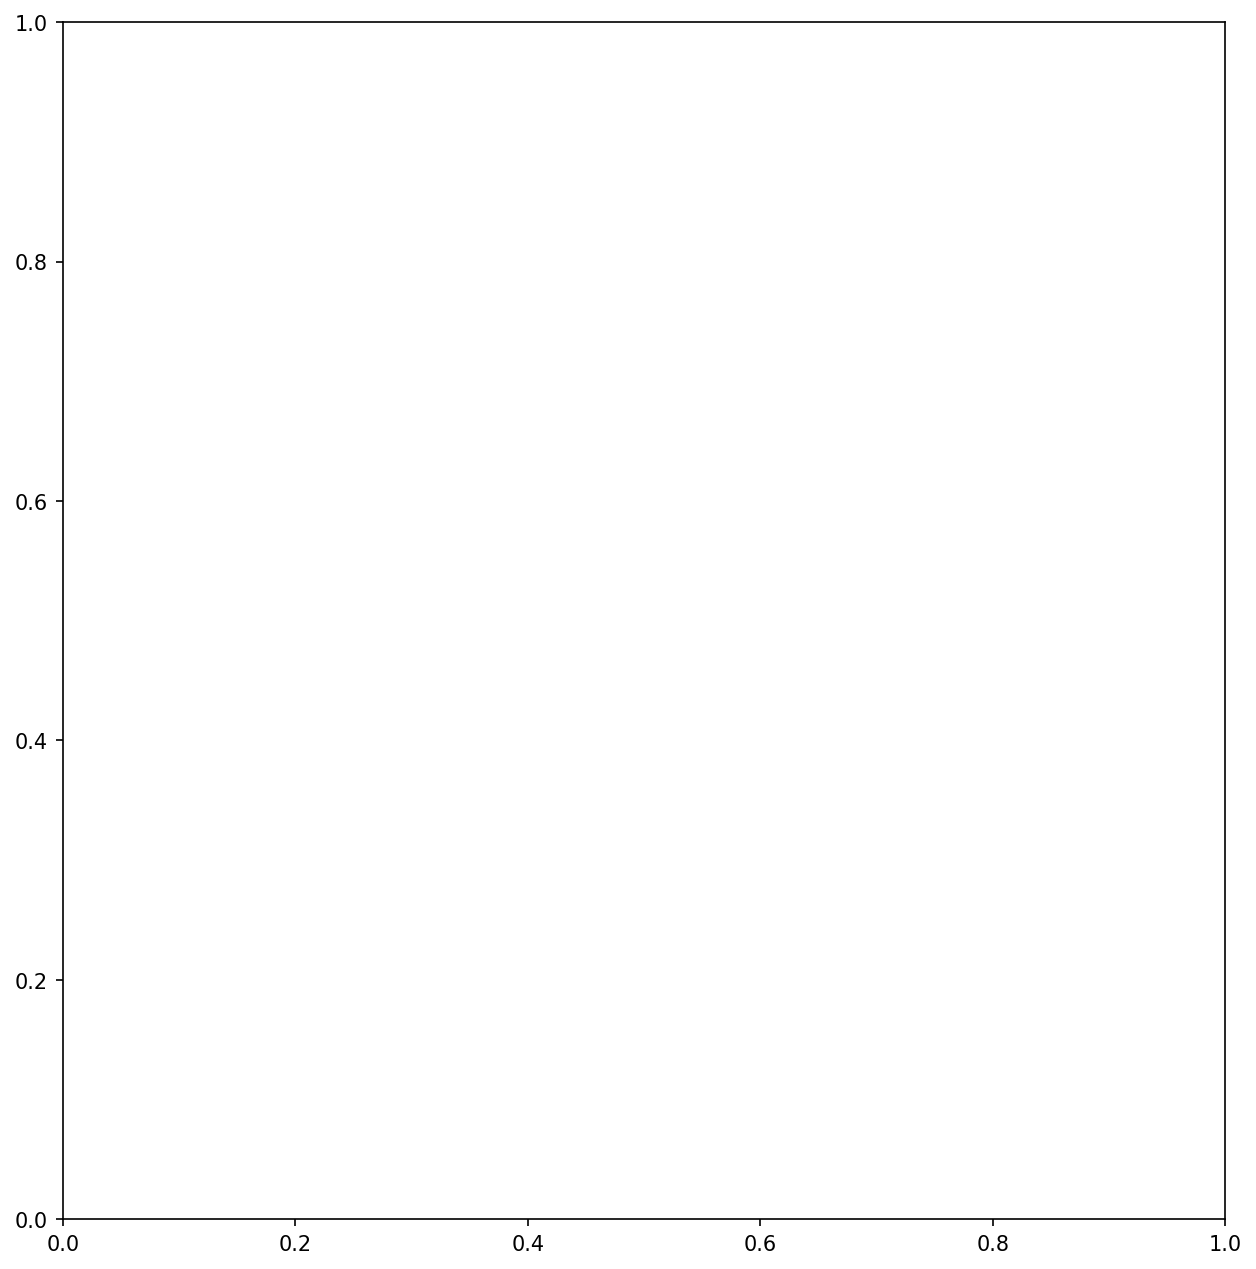

In [ ]:
# Gráfica subnacional de Banco Mundial.
# Number of hot days per year above 35°C, 2080-2099, RCP8.5

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Graficamos datos
gdf_sub.plot( ax = ax, column = v,  edgecolor = "white", linewidth = 0.05,
    cmap = "plasma_r", legend = True,
    vmin = 0, vmax = 365,
    #vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {
    "label": "Number of hot days per year above 35°C, 2080-2099, RCP8.5",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"}
    )

# Graficamos países
gdf0_50[ ~(gdf0_50.index == "ATA") ].boundary.plot(
    ax = ax, edgecolor = "black", linewidth = 0.25)

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

In [ ]:
# Unimos los vectores de la OECD

# Vectores subnacionales OECD
gdf_oe = gpd.read_file(map_d + map_f[4] ).rename(
    columns = {"iso3": ix, "tl2_id": "REF_AREA", "name_en": "NAME"}
    ).set_index("REF_AREA")[ [ix, "NAME", "geometry"] ]

# Archivos separados no OECD
gdf_noe = []
for f in map_f[5:]:
    gdf_noe.append( gpd.read_file(map_d + f).to_crs(4326))
gdf_noe[0] = gdf_noe[0].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[1] = gdf_noe[1].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[3] = gdf_noe[3].rename( columns = {"TL_CODE": "REF_AREA",
    "TL_NAME": "NAME", "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[4] = gdf_noe[4].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
# Unimos los archivos
gdf_noe = pd.concat( gdf_noe[0:2] + gdf_noe[3:] )[
    [ix, "NAME", "geometry"] ]

# Unimos todos los vectores subnacionales
gdf_oecd = pd.concat( [gdf_oe, gdf_noe] )

# Agregamos los vectores nacionales que no tienen datos subnacionales
gdf_countries = gdf0_50.loc[ ~gdf0_50.index.isin(gdf_oecd[ix].unique()),
    ["NAME", "geometry"] ]
gdf_countries.index = gdf_countries.index.rename("REF_AREA")
gdf_countries[ix] = gdf_countries.index
gdf_oecd = pd.concat( [gdf_oecd, gdf_countries] )

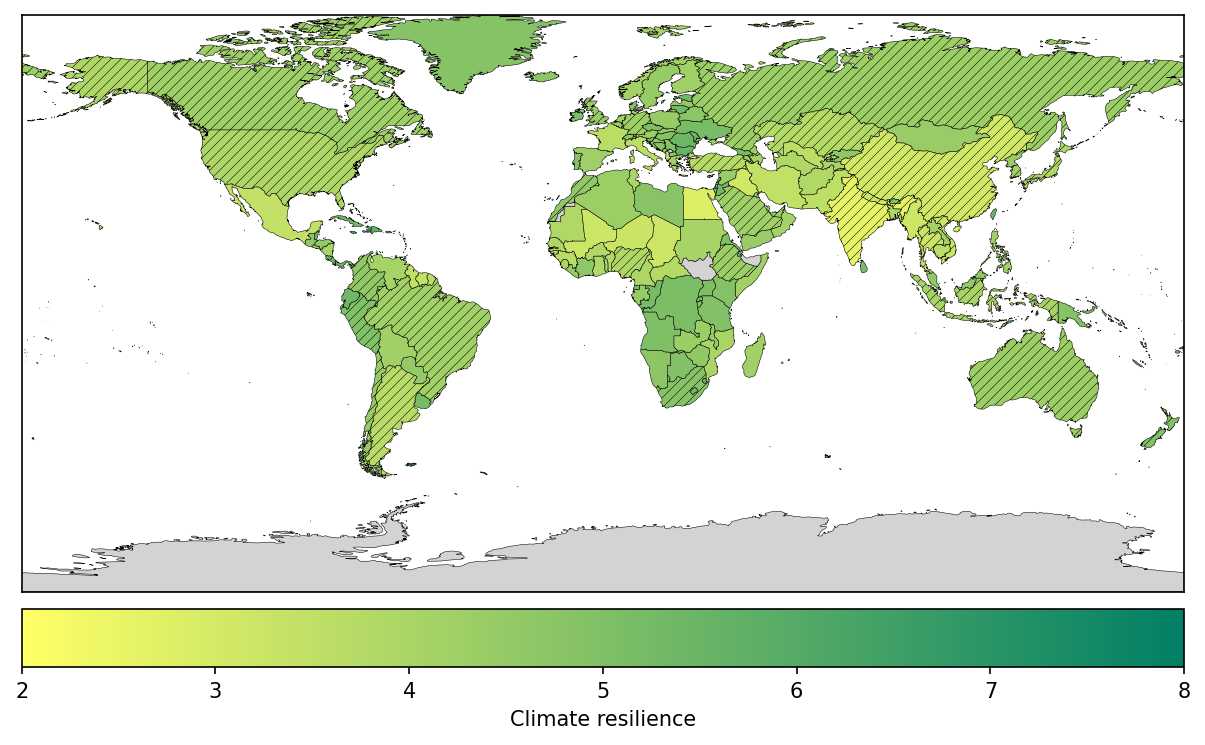

In [ ]:
# Gráfica de índice de resiliencia climática

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Ajustes de achurado
plt.rcParams["hatch.linewidth"] = 0.25

# Graficamos índice de resiliencia climática
gdf_3.plot( ax = ax, column = "Mean",  edgecolor = "black", linewidth = 0.25,
    cmap = "summer_r", legend = True,
    vmin = np.floor( gdf_3["Mean"].min() ),
    vmax = np.ceil( gdf_3["Mean"].max() ),
    legend_kwds = {"label": "Climate resilience",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

# Garficamos países con objetivo Net Zero
gdf_3[ ~gdf_3["Net Zero Rating"].isnull() ].plot( ax = ax,
    edgecolor = "black", color = "none",
    hatch = "/////", linewidth = 0 )

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

In [ ]:
# Cargamos datos de variable climática

# Base de datos y variable a usar
id = "EXT_TEMP"
v = "HD_POP_EXP"
dur = df_v.loc[df_v["Variable"] == v , "DURATION"].iloc[0]

# Cargamos el archivo
df = pd.read_csv( "../../" + df_c.loc[df_c["ID"] == id, "Path"].iloc[0]
    + df_c.loc[df_c["ID"] == id, "Filename"].iloc[0])

# Escogemos el tiempo y medida de interés
df_i = df[ (df["MEASURE"] == v) & (df["DURATION"] == dur) ]
df_i = df_i.sort_values( ["REF_AREA", "TIME_PERIOD"]
    ).drop_duplicates("REF_AREA", keep = "last").set_index("REF_AREA")

# Lo unimos a los datos geográficos
gdf_sub = gdf_oecd.merge(df_i, how = "left",
    left_index = True, right_index = True )

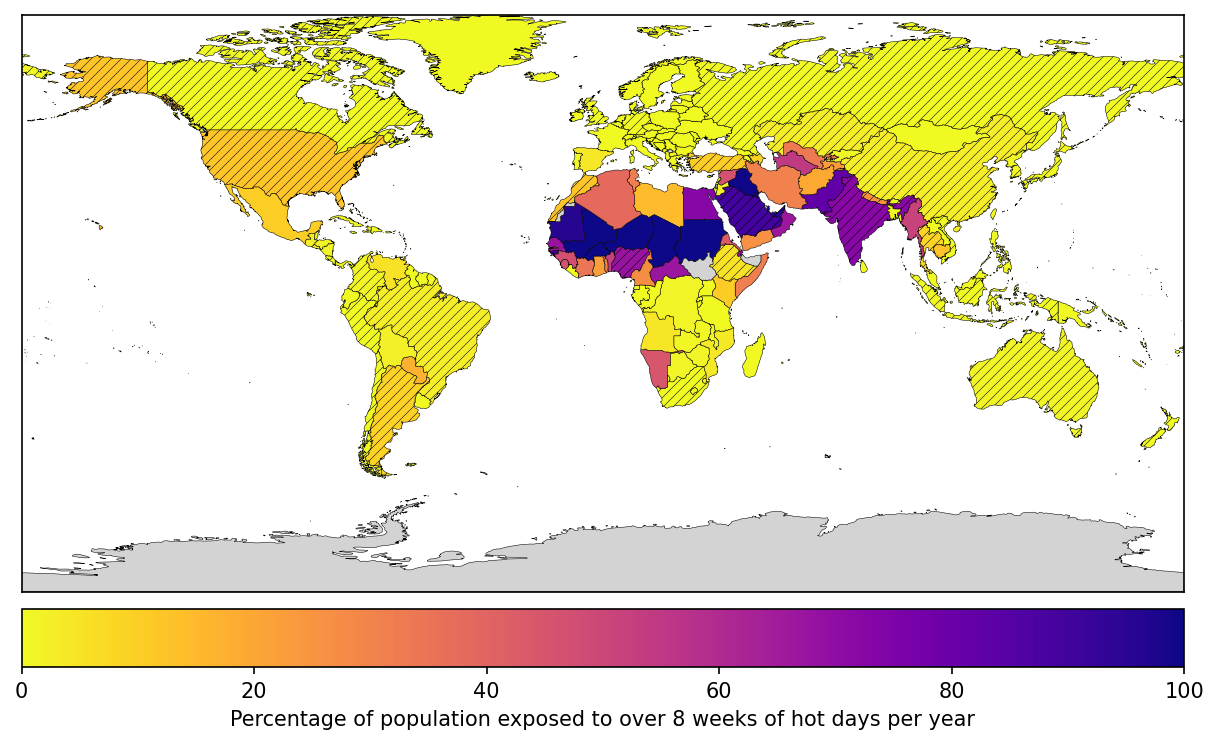

In [ ]:
# Percentage of population exposed to over 8 weeks of hot days per year
# Nacional

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Ajustes de achurado
plt.rcParams["hatch.linewidth"] = 0.25

# Variable a graficar
name = "Percentage of population exposed to over 8 weeks of hot days per year"
v = "HD_POP_EXP"

# Graficamos variable climática
gdf_4.plot( ax = ax, column = v,  edgecolor = "black", linewidth = 0.25,
    cmap = "plasma_r", legend = True,
    vmin = np.floor( gdf_4[v].min() ), vmax = np.ceil( gdf_4[v].max() ),
    legend_kwds = {"label": name,
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

# Garficamos países con objetivo Net Zero
gdf_4[ ~gdf_4["Net Zero Rating"].isnull() ].plot( ax = ax,
    edgecolor = "black", color = "none",
    hatch = "/////", linewidth = 0 )

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

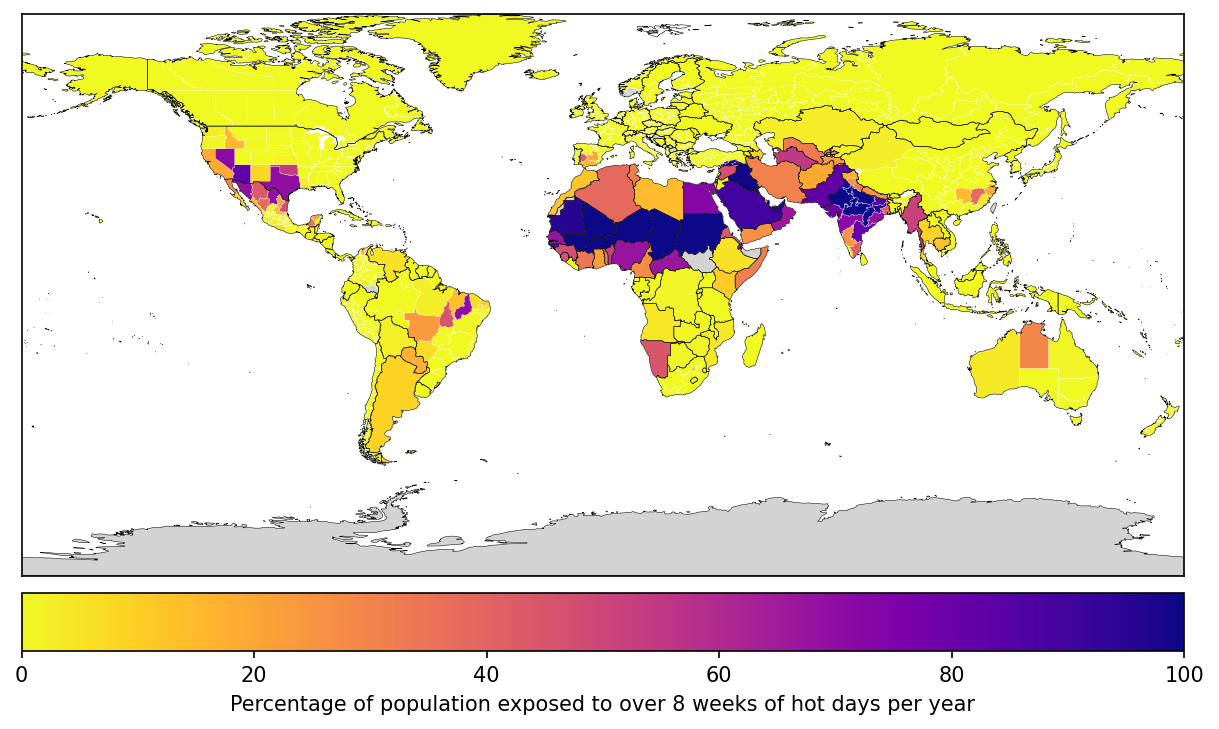

In [ ]:
# Percentage of population exposed to over 8 weeks of hot days per year
# Subnacional

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Variable a graficar
name = "Percentage of population exposed to over 8 weeks of hot days per year"
v = "OBS_VALUE"

# Graficamos variable climática
gdf_sub.plot( ax = ax, column = v,  edgecolor = "white", linewidth = 0.1,
    cmap = "plasma_r", legend = True,
    vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {"label": name,
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

# Graficamos fronteras nacionales
gdf0_50.boundary.plot(ax = ax, edgecolor = "black", linewidth = 0.25)

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()